# Settings

In [1]:
import sys

# set lib path just next to current path to give priority to modules in lib
sys.path.insert(sys.path.index('')+1, '/lib')

In [2]:
%load_ext autotime

import pandas as pd
import FinanceDataReader as fdr

from lib.fastquant import backtest_portfolio
from lib.utils import HiddenPrints, DATE_FORMAT
from datetime import datetime, timedelta

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np

time: 10.7 s (started: 2023-03-09 21:58:59 +09:00)


In [3]:
def run_backtest(start, df_bt, kwargs, proba=1, strategy='custom'):
    
    df = df_bt.copy()
    end = start + timedelta(hold_period)
    df = df.loc[start:end]
    if proba < 1:
        df.loc[:,'custom'] = df.custom.apply(lambda x:x*np.random.choice(2, 1, p=[1.-proba, proba])[0])
    df = {symbol: df}
    with HiddenPrints(mark_end=False):
        result = backtest_portfolio(strategy, df, start.strftime(DATE_FORMAT), end.strftime(DATE_FORMAT), **kwargs)
    #return result # testing
        
    #if np.isnan(result['history']['win_rate'].squeeze()):
    if result['history']['total'].squeeze() == 0:
        #return [start, end, None, None, None] # last col 'return' cast to NaT instead of None 
        return [start, end, -1, None, None]
    else:
        return [start, end] + result['summary']
    

def print_progress(i, print_step, last_print):
    n = round((i+1) / n_dates * 100)
    if n != last_print and n % (print_step*100) == 0:
        print(f'{n}% done')
        return n
    else:
        return last_print
    
    
def compare_models(df, ret_limit=None, figsize=(14, 5), width_ratios=[3, 1],
                   title="Strategy Comparison", orient='v', return_axes=False):
    
    kw_box = {'h': dict(y='scenario', x='return'),
             'v': dict(x='scenario', y='return')}
    kw_axline = dict(lw=1, ls='--', c='dimgray')

    fig = plt.figure(figsize=figsize)
    fig.suptitle(title)
    gs = GridSpec(1, 2, width_ratios=width_ratios)
    ax1 = fig.add_subplot(gs[0])
    #ax2 = fig.add_subplot(gs[1], sharey=ax1)
    ax2 = fig.add_subplot(gs[1])
    #fig.tight_layout()

    df = df.dropna(subset='return').reset_index()
    _ = sns.lineplot(data=df, x='start', y='return', hue='scenario', ax=ax1, lw=0.5)
    _ = sns.boxplot(data=df, ax=ax2, orient=orient, **kw_box[orient])

    _ = ax1.axhline(**kw_axline)
    _ = ax1.set_ylim(top=ret_limit)
    if orient == 'h':
        _ = ax2.axvline(**kw_axline)
        _ = ax2.set_xlim(right=ret_limit)
    else:
        _ = ax2.axhline(**kw_axline)
        _ = ax2.set_ylim(top=ret_limit)
    
    if return_axes:
        return (ax1, ax2)

time: 6.66 ms (started: 2023-03-09 21:59:09 +09:00)


In [4]:
import tulipy as ti


def calc_macd(df, periods=[12,26,9]):
    ind = ti.macd(df.astype(float).to_numpy(), *periods)

    name = 'macd'
    cols = [name, name+'_signal', name+'_histogram']
    
    index_size = len(df.index)
    indi = np.full((len(cols), index_size), np.nan)
    indi[:, index_size-ind[0].size:] = ind
    
    return pd.DataFrame(dict(zip(cols, indi)), index=df.index)


def calc_bbands(df, periods=[20,2]):
    ind = ti.bbands(df.astype(float).to_numpy(), *periods)

    name = 'bbands'
    cols = [name+'_lower', name+'_middle', name+'_upper']
    
    index_size = len(df.index)
    indi = np.full((len(cols), index_size), np.nan)
    indi[:, index_size-ind[0].size:] = ind
    
    return pd.DataFrame(dict(zip(cols, indi)), index=df.index)


def finish_custom(df_bt):
    df = df_bt.copy().sort_index()
    prv = 0
    for dt, (_, c) in df.iterrows():
        if c in [1, -1]:
            if c == prv:
                df.loc[dt, 'custom'] = 0
            else:
                prv = c
        else:
            prv = 0
    return df


def check_scenario(idx_nobuy, i=None, df_result=None):
    if df_result is None:
        n = len(idx_nobuy)
        if n > 0:
            print(f'{n} scenarios of no buy.')
        return None
    if pd.isnull(df_result.loc[i]['return']):
        idx_nobuy.append(i)
        n = len(idx_nobuy)
        if n < 2:
            print(f'{i}: No buy at all')
        elif n == 2:
            print('there are more scenarios of no buy.')
        else:
            pass
    return idx_nobuy

time: 45.2 ms (started: 2023-03-09 21:59:10 +09:00)


In [5]:
start = '20180101'
end = '20221231'

symbol = '069500' # KODEX 200
df_all = fdr.DataReader(symbol, start, end)

time: 300 ms (started: 2023-03-09 10:34:00 +09:00)


In [6]:
df_compare = pd.DataFrame()

time: 1.69 ms (started: 2023-03-09 10:34:00 +09:00)


# Buy & hold

## Settings

In [7]:
df_bt = (df_all.Close.rename_axis('dt').to_frame('close')
               .assign(custom=0))
dates_all = df_bt.index

time: 12.8 ms (started: 2023-02-28 18:29:39 +09:00)


In [8]:
hold_period = 365
dates_start = df_bt.loc[: dates_all[-1] - timedelta(hold_period)].index
n_dates = dates_start.size

time: 8.97 ms (started: 2023-02-28 18:29:40 +09:00)


In [9]:
kwargs_bt = {
    'init_cash': 1e7, 
    'commission': 0.00363960/100,
    'verbose': False, 
    'plot_bp':False,
    'buy_prop': 1,
    'sell_prop': 1,
    'upper_limit':0.1, 
    'lower_limit':-0.1
}

time: 6.83 ms (started: 2023-02-28 18:29:41 +09:00)


## SC01

In [10]:
scenario = 'b1'
n_buy = 1

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 1.03 ms (started: 2023-02-28 18:29:42 +09:00)


In [11]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

for i, start in enumerate(dates_start):
    df_bt['custom'] = 0 # reset
    df_bt.loc[start,'custom'] = -1
    
    res = run_backtest(start, df_bt, kwargs_bt)
    if res[2] <= 0:
        print('ERROR: no buy for buy&hold')
        break
    df_result.loc[i] = res
    
    n_last = print_progress(i, print_step, n_last)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 13min 5s (started: 2023-02-28 18:29:43 +09:00)


In [12]:
df_result['return'].agg(['mean','min','max'])

mean      7.878639
min     -29.578320
max     111.056006
Name: return, dtype: float64

time: 13.5 ms (started: 2023-02-28 18:42:49 +09:00)


In [13]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 13.7 ms (started: 2023-02-28 18:42:49 +09:00)


## SC02

In [14]:
scenario = 'b2'
n_buy = 10

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 4.29 ms (started: 2023-02-28 18:42:49 +09:00)


In [15]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

period = 20

for i, start in enumerate(dates_start):
    df_bt['custom'] = 0 # reset
    dt = dates_all[[i + x*period for x in range(n_buy)]]
    df_bt.loc[dt,'custom'] = -1
    
    res = run_backtest(start, df_bt, kwargs_bt)
    if res[2] <= 0:
        print('ERROR: no buy for buy&hold')
        break
    df_result.loc[i] = res
    n_last = print_progress(i, print_step, n_last)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 13min 59s (started: 2023-02-28 18:42:49 +09:00)


In [16]:
df_result['return'].agg(['mean','min','max'])

mean     3.414606
min    -16.512425
max     38.402674
Name: return, dtype: float64

time: 11.1 ms (started: 2023-02-28 18:56:49 +09:00)


In [17]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 14.6 ms (started: 2023-02-28 18:56:49 +09:00)


## SC03

In [18]:
scenario = 'b3'
n_buy = 20

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 1.17 ms (started: 2023-02-28 18:56:49 +09:00)


In [19]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

period = 10

for i, start in enumerate(dates_start):
    df_bt['custom'] = 0 # reset
    dt = dates_all[[i + x*period for x in range(n_buy)]]
    df_bt.loc[dt,'custom'] = -1
    
    res = run_backtest(start, df_bt, kwargs_bt)
    if res[2] <= 0:
        print('ERROR: no buy for buy&hold')
        break
    df_result.loc[i] = res
    n_last = print_progress(i, print_step, n_last)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 15min 19s (started: 2023-02-28 18:56:49 +09:00)


In [20]:
df_result['return'].agg(['mean','min','max'])

mean     3.217287
min    -16.298809
max     36.433602
Name: return, dtype: float64

time: 18.9 ms (started: 2023-02-28 19:12:08 +09:00)


In [21]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 11.7 ms (started: 2023-02-28 19:12:08 +09:00)


In [23]:
df_compare.to_csv('df_compare1_tmp.csv')

time: 85.4 ms (started: 2023-02-28 19:12:09 +09:00)


## Compare

In [55]:
df = df_compare.loc[df_compare.scenario.str.startswith('b')]

time: 12.4 ms (started: 2023-03-01 09:32:03 +09:00)


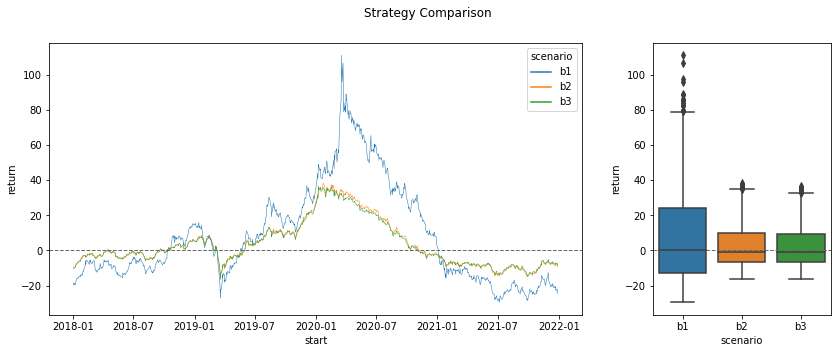

time: 1.26 s (started: 2023-03-01 09:32:04 +09:00)


In [56]:
compare_models(df)

# Technical Indicator

## Settings

In [7]:
df_bt_ori = (df_all.Close.rename_axis('dt').to_frame('close')
               .assign(custom=0))
dates_all = df_bt_ori.index

time: 19.2 ms (started: 2023-03-08 21:24:07 +09:00)


In [8]:
hold_period = 365
dates_start = df_bt_ori.loc[: dates_all[-1] - timedelta(hold_period)].index
n_dates = dates_start.size

time: 7.29 ms (started: 2023-03-08 21:24:07 +09:00)


In [9]:
kwargs_bt = {
    'init_cash': 1e7, 
    'commission': 0.00363960/100,
    'verbose': False, 
    'plot_bp':False,
    'buy_prop': 1,
    'sell_prop': 1,
    'upper_limit':0.1, 
    'lower_limit':-0.1
}

time: 1.05 ms (started: 2023-03-08 21:24:08 +09:00)


In [10]:
# testing
#dates_start = dates_start[400:500]

time: 634 µs (started: 2023-03-08 21:24:09 +09:00)


In [19]:
df_compare = pd.read_csv('df_compare1.csv', index_col=0, parse_dates=['start'])
#df_compare = df_compare.loc[~df_compare.scenario.startswith('t')]

time: 46.9 ms (started: 2023-03-08 21:39:36 +09:00)


In [20]:
df_compare.groupby(by=['scenario']).agg(['mean','median','min','max','std','count'])

return                                                  
              mean    median        min         max        std count
scenario                                                            
b1        7.878639  0.402187 -29.578320  111.056006  27.575498   985
b2        3.414606 -0.903985 -16.512425   38.402674  13.113664   985
b3        3.217287 -0.755533 -16.298809   36.433602  12.425961   985
t1a       8.054669  0.013180 -12.013608   57.532364  17.799612   985
t1b       4.636345 -0.655828  -6.153420   36.403294  10.678585   985
t1c       1.854880 -0.513834  -3.162596   16.136710   4.728399   985
t1d       7.139184 -0.369959 -28.178184   63.350118  18.064121   983
t2a      -1.312248 -1.233531 -25.756412   20.074891  10.610954   985
t2b      -1.386416  0.792652 -24.544178   13.952202   9.154896   985
t2c      -1.476501  0.882640 -20.921568    6.389692   6.378838   985
t2d      -1.315268  0.048280 -19.091197   16.680429   5.232895   965
t3        2.108161  1.711919  -1.706558    6.489749   2.117371   969

time: 53.3 ms (started: 2023-03-08 21:39:37 +09:00)


In [24]:
df_compare = df_compare.loc[~df_compare.scenario.str.startswith('t1') & ~df_compare.scenario.str.startswith('t3')]

time: 26.8 ms (started: 2023-03-08 21:41:49 +09:00)


In [27]:
df_compare.groupby(by=['scenario']).agg(['mean','median','min','max','std','count'])

return                                                  
              mean    median        min         max        std count
scenario                                                            
b1        7.878639  0.402187 -29.578320  111.056006  27.575498   985
b2        3.414606 -0.903985 -16.512425   38.402674  13.113664   985
b3        3.217287 -0.755533 -16.298809   36.433602  12.425961   985
t1a       1.556658  3.661175 -26.716204   16.863314  10.183966   985
t2a      -1.312248 -1.233531 -25.756412   20.074891  10.610954   985
t2b      -1.386416  0.792652 -24.544178   13.952202   9.154896   985
t2c      -1.476501  0.882640 -20.921568    6.389692   6.378838   985
t2d      -1.315268  0.048280 -19.091197   16.680429   5.232895   965

time: 70.2 ms (started: 2023-03-08 21:42:19 +09:00)


## SC01: MACD

### calc tech indi

In [11]:
df_bt = df_bt_ori.copy()
df_macd = calc_macd(df_bt['close'])

time: 15.4 ms (started: 2023-03-08 21:24:10 +09:00)


In [12]:
df_ti = df_macd

# long
cond = (df_ti.macd > df_ti.macd_signal) 
cond = cond & (df_ti.macd < 0)
df_bt.loc[cond, 'custom'] = -1

# short
cond = (df_ti.macd < df_ti.macd_signal) 
cond = cond & (df_ti.macd > 0)
df_bt.loc[cond, 'custom'] = 1

time: 10.9 ms (started: 2023-03-08 21:24:13 +09:00)


In [13]:
df_bt = finish_custom(df_bt)

time: 297 ms (started: 2023-03-08 21:24:13 +09:00)


In [14]:
# small number of chance to buy
df_bt.custom.value_counts()

 0    1166
-1      33
 1      33
Name: custom, dtype: int64

time: 28.7 ms (started: 2023-03-08 21:24:14 +09:00)


### bactesting 1

In [16]:
scenario = 't1a'

kwargs_bt.update({
    'buy_prop': 1,
    'sell_prop': 1
})

time: 1.03 ms (started: 2023-03-08 21:25:49 +09:00)


In [17]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 13min 23s (started: 2023-03-08 21:25:52 +09:00)


In [18]:
df_result['return'].agg(['mean','min','max'])

mean     1.556658
min    -26.716204
max     16.863314
Name: return, dtype: float64

time: 23.1 ms (started: 2023-03-08 21:39:16 +09:00)


In [26]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 15.1 ms (started: 2023-03-08 21:42:11 +09:00)


### bactesting 2

In [28]:
scenario = 't1b'

kwargs_bt.update({
    'buy_prop': 0.5,
    'sell_prop': 0.5
})

time: 1.01 ms (started: 2023-03-08 21:43:00 +09:00)


In [29]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 14min 4s (started: 2023-03-08 21:43:01 +09:00)


In [30]:
df_result['return'].agg(['mean','min','max'])

mean    -0.068062
min    -23.635204
max     11.036617
Name: return, dtype: float64

time: 22.5 ms (started: 2023-03-08 21:57:05 +09:00)


In [31]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 8.72 ms (started: 2023-03-08 21:57:05 +09:00)


### bactesting 3

In [32]:
scenario = 't1c'

kwargs_bt.update({
    'buy_prop': 0.2,
    'sell_prop': 0.2
})

time: 1.04 ms (started: 2023-03-08 21:57:05 +09:00)


In [33]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 15min 7s (started: 2023-03-08 21:57:05 +09:00)


In [34]:
df_result['return'].agg(['mean','min','max'])

mean    -0.687544
min    -15.915653
max      4.961758
Name: return, dtype: float64

time: 9.97 ms (started: 2023-03-08 22:12:12 +09:00)


In [35]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 9.64 ms (started: 2023-03-08 22:12:12 +09:00)


### bactesting 4

In [36]:
scenario = 't1d'

kwargs_bt.update({
    'buy_prop': 1,
    'sell_prop': 1
})

proba = 0.8

time: 7.18 ms (started: 2023-03-08 22:12:12 +09:00)


In [37]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt, proba)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10% done
20% done
30% done
349: No buy at all
there are more scenarios of no buy.
40% done
50% done
60% done
70% done
80% done
90% done
100% done
32 scenarios of no buy.
time: 17min 8s (started: 2023-03-08 22:12:12 +09:00)


In [38]:
df_result['return'].agg(['mean','min','max'])

mean     1.005820
min    -26.213194
max     34.911104
Name: return, dtype: float64

time: 27.7 ms (started: 2023-03-08 22:29:21 +09:00)


In [39]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 17.7 ms (started: 2023-03-08 22:29:21 +09:00)


In [50]:
df_compare.to_csv('df_compare1_tmp2.csv')

time: 182 ms (started: 2023-02-28 20:41:10 +09:00)


### compare

In [40]:
df = df_compare.loc[df_compare.scenario.str.startswith('t1')]

time: 31.7 ms (started: 2023-03-08 22:29:21 +09:00)


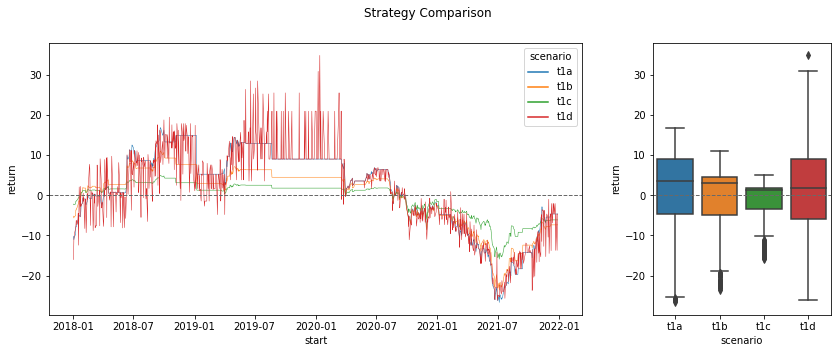

time: 1.65 s (started: 2023-03-08 22:29:21 +09:00)


In [41]:
compare_models(df)

## SC02: Bollinger Bands

### calc tech indi

In [52]:
df_bt = df_bt_ori.copy()
df_bbands = calc_bbands(df_bt['close'])
#df_bbands = calc_bbands(df_bt['close'], [20, 1])

time: 5.59 ms (started: 2023-02-28 20:41:12 +09:00)


In [53]:
df_ti = df_bbands

cond = df_bt.close < df_ti.bbands_lower
df_bt.loc[cond, 'custom'] = -1

cond = df_bt.close > df_ti.bbands_upper
df_bt.loc[cond, 'custom'] = 1

time: 6.91 ms (started: 2023-02-28 20:41:12 +09:00)


In [54]:
df_bt = finish_custom(df_bt)

time: 191 ms (started: 2023-02-28 20:41:12 +09:00)


In [55]:
df_bt.custom.value_counts()

 0    1157
-1      42
 1      33
Name: custom, dtype: int64

time: 11 ms (started: 2023-02-28 20:41:12 +09:00)


### bactesting 1

In [56]:
scenario = 't2a'

kwargs_bt.update({
    'buy_prop': 1,
    'sell_prop': 1
})

time: 988 µs (started: 2023-02-28 20:41:12 +09:00)


In [57]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 28min 46s (started: 2023-02-28 20:41:12 +09:00)


In [58]:
df_result['return'].agg(['mean','min','max'])

mean    -1.312248
min    -25.756412
max     20.074891
Name: return, dtype: float64

time: 12.7 ms (started: 2023-02-28 21:09:59 +09:00)


In [59]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 11.4 ms (started: 2023-02-28 21:09:59 +09:00)


### bactesting 2

In [60]:
scenario = 't2b'

kwargs_bt.update({
    'buy_prop': 0.5,
    'sell_prop': 0.5
})

time: 993 µs (started: 2023-02-28 21:09:59 +09:00)


In [61]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 33min 41s (started: 2023-02-28 21:09:59 +09:00)


In [62]:
df_result['return'].agg(['mean','min','max'])

mean    -1.386416
min    -24.544178
max     13.952202
Name: return, dtype: float64

time: 10.1 ms (started: 2023-02-28 21:43:41 +09:00)


In [63]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 23.7 ms (started: 2023-02-28 21:43:41 +09:00)


### bactesting 3

In [64]:
scenario = 't2c'

kwargs_bt.update({
    'buy_prop': 0.2,
    'sell_prop': 0.2
})

time: 1.4 ms (started: 2023-02-28 21:43:41 +09:00)


In [65]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 38min 58s (started: 2023-02-28 21:43:41 +09:00)


In [66]:
df_result['return'].agg(['mean','min','max'])

mean    -1.476501
min    -20.921568
max      6.389692
Name: return, dtype: float64

time: 12 ms (started: 2023-02-28 22:22:39 +09:00)


In [67]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 13 ms (started: 2023-02-28 22:22:39 +09:00)


### bactesting 4

In [68]:
scenario = 't2d'

kwargs_bt.update({
    'buy_prop': 0.2,
    'sell_prop': 0.2
})

proba = 0.5

time: 1.16 ms (started: 2023-02-28 22:22:40 +09:00)


In [69]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt, proba)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

8: No buy at all
10% done
20% done
there are more scenarios of no buy.
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
20 scenarios of no buy.
time: 45min 27s (started: 2023-02-28 22:22:40 +09:00)


In [70]:
df_result['return'].agg(['mean','min','max'])

mean    -1.315268
min    -19.091197
max     16.680429
Name: return, dtype: float64

time: 28 ms (started: 2023-02-28 23:08:07 +09:00)


In [71]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 18.8 ms (started: 2023-02-28 23:08:07 +09:00)


In [72]:
df_compare.to_csv('df_compare1_tmp3.csv')

time: 312 ms (started: 2023-02-28 23:08:07 +09:00)


### compare

In [59]:
df = df_compare.loc[df_compare.scenario.str.startswith('t2')]

time: 20.9 ms (started: 2023-03-01 09:32:22 +09:00)


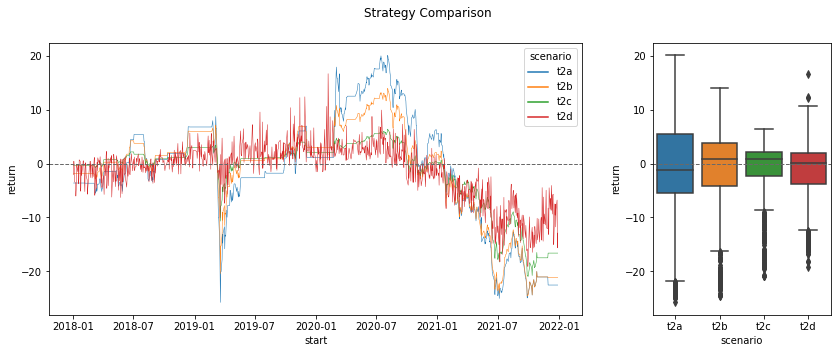

time: 1.36 s (started: 2023-03-01 09:32:23 +09:00)


In [60]:
compare_models(df)

## SC03: Bollinger Bands & MACD

### calc tech indi

In [42]:
df_bt = df_bt_ori.copy()
df_macd = calc_macd(df_bt['close'])
df_bbands = calc_bbands(df_bt['close'])

time: 9.15 ms (started: 2023-03-08 22:29:23 +09:00)


In [43]:
cond = (df_macd.macd > df_macd.macd_signal) & (df_macd.macd < 0)
cond = cond + (df_bt.close < df_bbands.bbands_lower)
df_bt.loc[cond, 'custom'] = -1

cond = (df_macd.macd < df_macd.macd_signal) & (df_macd.macd > 0)
cond = cond + (df_bt.close > df_bbands.bbands_lower)
df_bt.loc[cond, 'custom'] = 1

time: 17.9 ms (started: 2023-03-08 22:29:23 +09:00)


In [44]:
df_bt = finish_custom(df_bt)

time: 521 ms (started: 2023-03-08 22:29:23 +09:00)


In [45]:
df_bt.custom.value_counts()

 0    1166
 1      33
-1      33
Name: custom, dtype: int64

time: 15.1 ms (started: 2023-03-08 22:29:24 +09:00)


### bactesting

In [46]:
scenario = 't3'

kwargs_bt.update({
    'buy_prop': 1,
    'sell_prop': 1
})

time: 1.18 ms (started: 2023-03-08 22:29:24 +09:00)


In [47]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 18min 54s (started: 2023-03-08 22:29:24 +09:00)


In [48]:
df_result['return'].agg(['mean','min','max'])

mean    -6.252503
min    -23.146942
max      5.001180
Name: return, dtype: float64

time: 12 ms (started: 2023-03-08 22:48:18 +09:00)


In [49]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 10.6 ms (started: 2023-03-08 22:48:18 +09:00)


In [50]:
df_compare.to_csv('df_compare_1.csv')

time: 364 ms (started: 2023-03-08 22:48:18 +09:00)


### compare

In [51]:
models = ['t1a', 't2a', 't3']
df = df_compare.loc[df_compare.scenario.isin(models)]

time: 18.5 ms (started: 2023-03-08 22:48:44 +09:00)


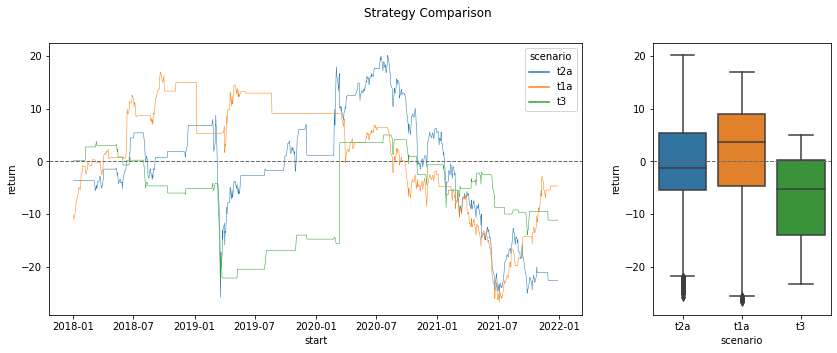

time: 1.3 s (started: 2023-03-08 22:48:48 +09:00)


In [52]:
compare_models(df)

# Comparison

## Visualization

In [63]:
df_compare = (pd.read_csv('df_compare_1.csv', index_col=0, parse_dates=['start'])
                .reset_index().sort_values(['scenario','start']).set_index('start')
)
#df_compare

time: 46.2 ms (started: 2023-03-08 22:55:09 +09:00)


In [64]:
df_compare.groupby(by=['scenario']).agg(['mean','median','min','max','std','count'])

return                                                  
              mean    median        min         max        std count
scenario                                                            
b1        7.878639  0.402187 -29.578320  111.056006  27.575498   985
b2        3.414606 -0.903985 -16.512425   38.402674  13.113664   985
b3        3.217287 -0.755533 -16.298809   36.433602  12.425961   985
t1a       1.556658  3.661175 -26.716204   16.863314  10.183966   985
t1b      -0.068062  3.009612 -23.635204   11.036617   7.599836   985
t1c      -0.687544  1.288885 -15.915653    4.961758   4.438906   985
t1d       1.005820  1.703590 -26.213194   34.911104  10.811974   953
t2a      -1.312248 -1.233531 -25.756412   20.074891  10.610954   985
t2b      -1.386416  0.792652 -24.544178   13.952202   9.154896   985
t2c      -1.476501  0.882640 -20.921568    6.389692   6.378838   985
t2d      -1.315268  0.048280 -19.091197   16.680429   5.232895   965
t3       -6.252503 -5.141189 -23.146942    5.001180   7.900163   985

time: 60.3 ms (started: 2023-03-08 22:55:10 +09:00)


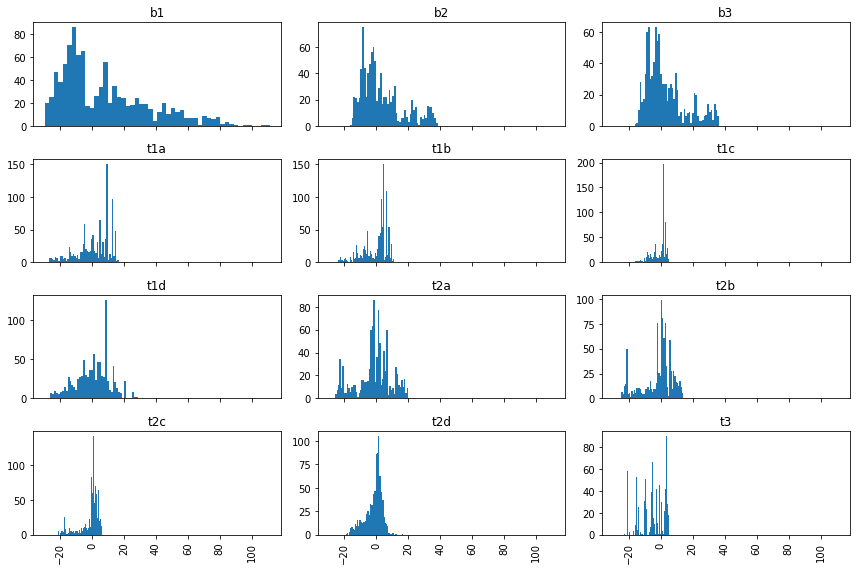

time: 8.45 s (started: 2023-03-08 22:55:13 +09:00)


In [65]:
_ = df_compare.hist(by='scenario', column='return', figsize=(12,8), bins=50, sharex=True)
plt.tight_layout()

In [66]:
df = (df_compare
      #.loc[df_compare.scenario.str.startswith('t2')]
      .loc[df_compare.scenario.isin(['b1', 't1a', 't2a', 't3'])]
     )

time: 4.84 ms (started: 2023-03-08 22:55:28 +09:00)


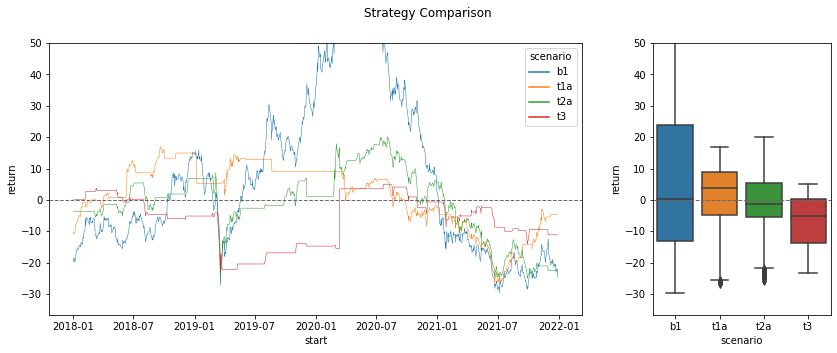

time: 1.46 s (started: 2023-03-08 22:55:29 +09:00)


In [67]:
#compare_models(df, 50, orient='h')
compare_models(df, 50)

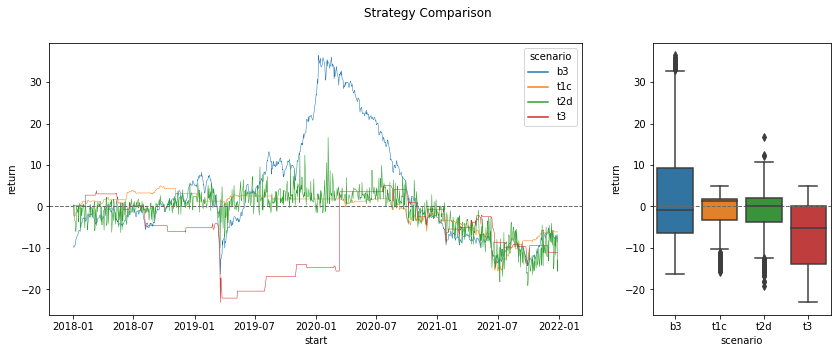

time: 1.4 s (started: 2023-03-08 22:55:37 +09:00)


In [68]:
models = ['b3', 't1c', 't2d', 't3']
df = df_compare.loc[df_compare.scenario.isin(models)]
     
compare_models(df)

## Bayesian estimation

### Settings

In [5]:
import pymc3 as pm
import arviz
from matplotlib import gridspec
from matplotlib.lines import Line2D
from scipy import stats

YEAR = 252
midx = pd.IndexSlice
DATE_FILE = '%y%m%d'


    
def bayesian_estimate(df_returns, draws=10000, tune=2500, burnin=0,
                      chains=4, target_accept=.9, inspect_mode=False, 
                      figsize=(10, 14), loc_legend='upper right',
                      plot_trace=True, save_plot=False, save_path=None):
    """
    Bayesian hypothesis test to compare two return distributions. 
    Returns are assumed to be T-distributed.
    can run with more than 2 return dists but no comparison then
    """
    if not isinstance(df_returns, pd.Series):
        print('ERROR: df_returns is not series')
        return
    else:
        df_returns = df_returns.dropna()
        lvl1, _ = df_returns.index.names
        
    # priors
    mean_prior, std_prior = df_returns.mean(), df_returns.std()
    std_low, std_high = std_prior / 1000, std_prior * 1000
    T = YEAR ** .5
    mean, std, returns = {}, {}, {}
    groups = df_returns.index.get_level_values(lvl1).unique()
    num_groups = len(groups) # flag to plot comparisio if comparing two hists
    
    with pm.Model() as model:
        nu = pm.Exponential('nu_minus_two', 1 / 29, testval=4) + 2.
        for i, g in enumerate(groups):
            df_g = df_returns.loc[midx[g]]
            mean[i] = pm.Normal(f'mean_{g}', mu=mean_prior, sd=std_prior, testval=df_g.mean())
            std[i] = pm.Uniform(f'std_{g}', lower=std_low, upper=std_high, testval=df_g.std())
            returns[i] = pm.StudentT(f'returns_{g}', nu=nu, mu=mean[i], sd=std[i], observed=df_g)
            pm.Deterministic(f'vol_{g}', returns[i].distribution.sd * T)
            pm.Deterministic(f'sharpe_{g}', returns[i].distribution.mean / returns[i].distribution.sd * T)
        if num_groups == 2:
            mean_diff = pm.Deterministic('mean diff', mean[0] - mean[1])
            pm.Deterministic('std diff', std[0] - std[1])
            pm.Deterministic('effect size', mean_diff / (std[0] ** 2 + std[1] ** 2) ** .5 / 2)

    if inspect_mode:
        pm.model_to_graphviz(model=model)

    with model:
        # HMC NUTS Sampling
        #cores, _ = print_machine_type()
        trace = pm.sample(draws=draws, tune=tune,
                          chains=chains, 
                          #cores=cores,
                          target_accept=target_accept,
                          #return_inferencedata=False, # TODO: what's for?
                          progressbar=True)
    #pm.trace_to_dataframe(trace).info()


    ### plot & compare
    # To compare the performance of two return series, we model each group’s Sharpe ratio separately 
    # and compute the effect size as the difference between the volatility-adjusted returns.
    plot_bayesian_returns(trace, groups, burnin, figsize, loc_legend, 
                                 save_plot, save_path)

    # TODO: implement
    #arviz.plot_forest(data=trace)

    if plot_trace:
        plot_traces(trace, burnin=burnin, fig_width=figsize[0])
        
    #return (trace, groups) # testing


def plot_bayesian_returns(trace, groups, 
                            burnin=0, figsize=(12, 16), loc_legend='upper right',
                            save=True, path=None):
    trace = trace[burnin:]
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    num_groups = len(groups)
    if num_groups == 2:
        cols = 2
    else:
        cols = 1
    gs = gridspec.GridSpec(4, cols, wspace=0.1, hspace=0.4)
    axs = [plt.subplot(gs[i, j]) for i in [0, 1, 2] for j in [0, 1]]
    axs.append(plt.subplot(gs[3, :]))
    vl_style = {'ls':'--', 'lw':0.7, 'c':'black',}
    
    kw_hist = dict(kde=True, stat="density", kde_kws=dict(cut=3), 
                   alpha=.4, edgecolor=(1, 1, 1, .4))

    def distplot_w_perc(trace, ax, p=2.5):
        sns.histplot(trace, ax=ax, **kw_hist)
        ps = [stats.scoreatpercentile(trace, x) for x in [p, 100-p]]
        ax.axvline(ps[0], **vl_style)
        ax.axvline(ps[1], **vl_style)
        line = Line2D([0,1],[0,1], **vl_style)
        ax.legend([line], ['2.5 & 97.5\npercentiles'],
                  loc=loc_legend, 
                  #frameon=True, framealpha=0.5
                 )
        display_credible(trace, ax, ref=0, alen=0.2*(ps[1]-ps[0]))

    def display_credible(trace, ax, ref=0, alen=1):
        if trace.min() < ref < trace.max():
            c = 'mediumblue'
            ax.axvline(ref,  lw=0.5, c=c)
            x = stats.percentileofscore(trace, ref)
            if x < 50:
                x = 100 - x
                ha = 'left'
            else:
                ha = 'right'
                alen = -alen
            a = np.mean(ax.get_ylim())
            ax.annotate(f'{x:.0f}%', 
                          xy=(ref, a), 
                          xycoords='data', 
                          xytext=(ref+alen, a), 
                          textcoords='data', 
                          ha=ha, 
                          va='center',
                          fontsize='large', 
                          color=c,
                          arrowprops=dict(edgecolor=c, width=20, headwidth=30, alpha=0.5)
                       )

    vs = ['mean', 'vol', 'sharpe']
    vsl = ['Mean', 'Annual volatility', 'Sharpe ratio']
    for i, v in enumerate(vs):
        dfs = [pd.DataFrame(trace[f'{v}_{g}'], columns=[v]).assign(model=g) for g in groups]
        sns.histplot(data=pd.concat(dfs).reset_index(), x=v, hue='model', ax=axs[i*num_groups], **kw_hist)
        axs[i*num_groups].set(xlabel=vsl[i], ylabel='Belief', yticklabels=[])

    if num_groups == 2:
        distplot_w_perc(trace['mean diff'], axs[1])
        distplot_w_perc(trace[f'vol_{groups[0]}'] - trace[f'vol_{groups[1]}'], axs[3])
        distplot_w_perc(trace[f'sharpe_{groups[0]}'] - trace[f'sharpe_{groups[1]}'], axs[5]) 
        distplot_w_perc(trace['effect size'], axs[6])

        axs[1].set(xlabel='Difference of means', yticklabels=[])
        axs[3].set(xlabel='Difference of volatility', yticklabels=[])
        axs[5].set(xlabel='Difference of Sharpes', yticklabels=[])
        axs[6].set(xlabel='Difference of means normalized by volatility', ylabel='Belief', yticklabels=[])
    sns.despine()
    fig.tight_layout()
    
    if save:
        dt = datetime.today().strftime(DATE_FILE)
        file = f'bayesian_returns2_{dt}.png'
        path = get_path(path)
        file = check_file_name(file, path)
        plt.savefig(path / file) # save as png type
        print(f'{file} saved.')


def plot_traces(traces, burnin=0, fig_width=12, height_unit=1.8):
    """ 
    Plot traces with overlaid means and values
    """
    summary = arviz.summary(traces[burnin:])['mean'].to_dict()
    ax = arviz.plot_trace(traces[burnin:],
                      figsize=(fig_width, len(traces.varnames)*height_unit),
                      lines=summary)
    for i, mn in enumerate(summary.values()):
        ax[i, 0].annotate(f'{mn:.2f}', 
                          xy=(mn, 0), 
                          xycoords='data', 
                          xytext=(5, 10), 
                          textcoords='offset points', 
                          rotation=90, 
                          va='bottom', 
                          fontsize='large', 
                          color='#AA0022')

time: 3.25 s (started: 2023-03-09 21:59:10 +09:00)


### CS01

In [42]:
df = df_compare.loc[df_compare.scenario.isin(['b1','b2'])].reset_index().set_index(['scenario', 'start']).squeeze().dropna()

time: 13.4 ms (started: 2023-02-28 08:51:54 +09:00)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [std_b2, mean_b2, std_b1, mean_b1, nu_minus_two]


Sampling 4 chains for 2_500 tune and 10_000 draw iterations (10_000 + 40_000 draws total) took 458 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


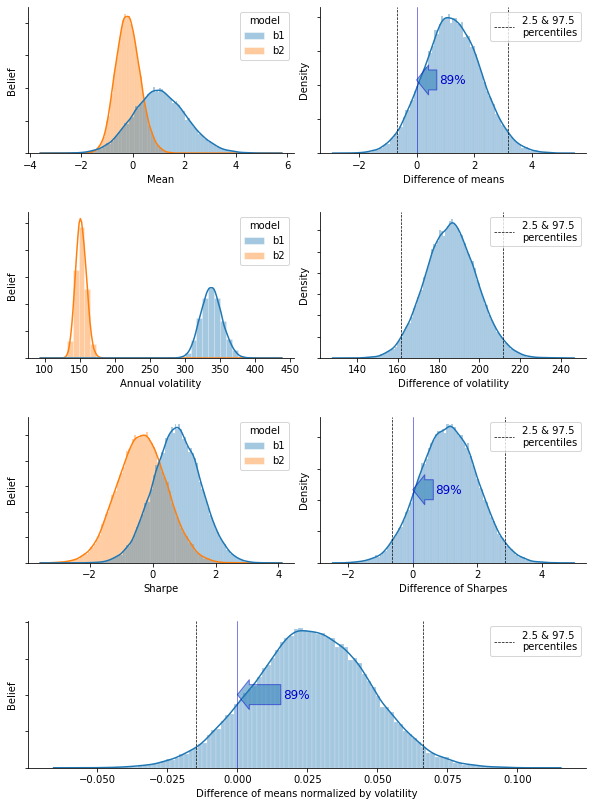

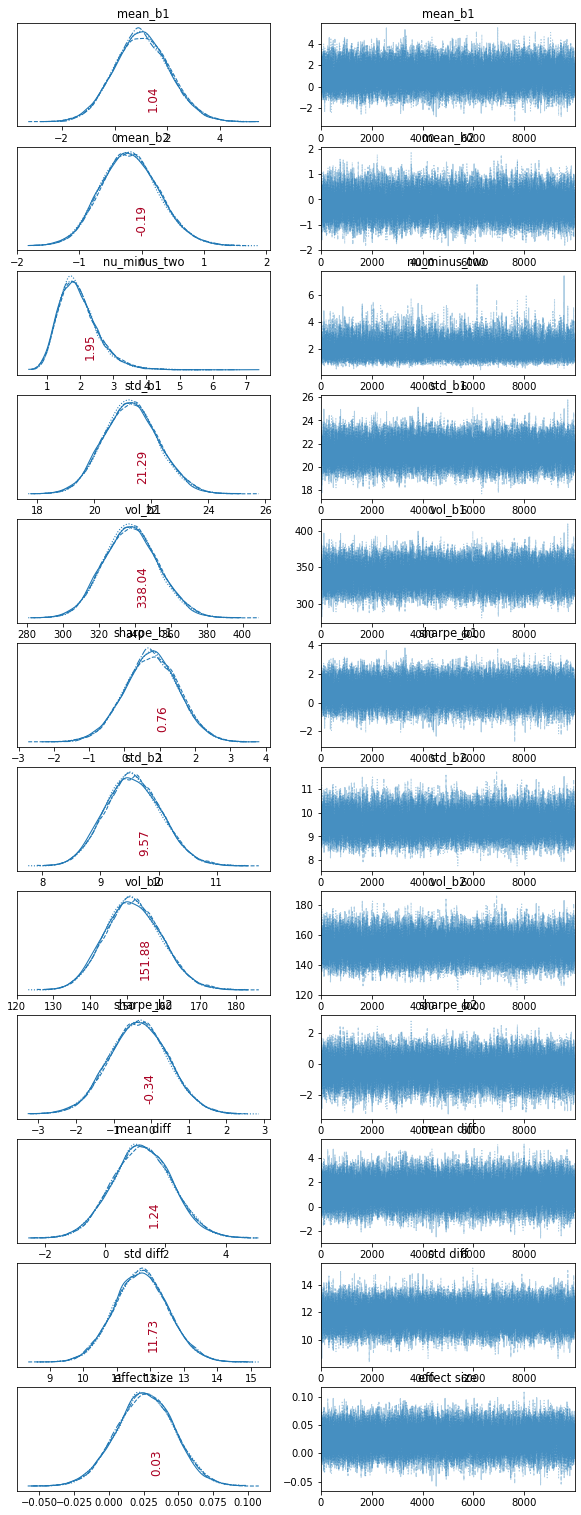

time: 10min 46s (started: 2023-02-28 12:20:47 +09:00)


In [194]:
# proba that strategy b1 outperforms b2 is 89%. but b1 is more volatile.
bayesian_estimate(df)

### CS02

In [70]:
df = df_compare.loc[df_compare.scenario.isin(['b1','t1a'])].reset_index().set_index(['scenario', 'start']).squeeze()

time: 24.4 ms (started: 2023-03-08 22:56:17 +09:00)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [std_t1a, mean_t1a, std_b1, mean_b1, nu_minus_two]


Sampling 4 chains for 2_500 tune and 10_000 draw iterations (10_000 + 40_000 draws total) took 436 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


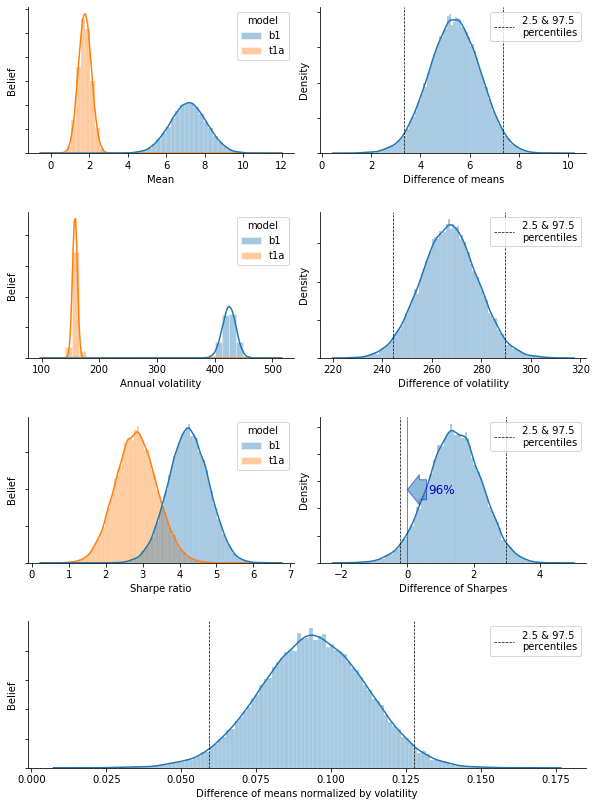

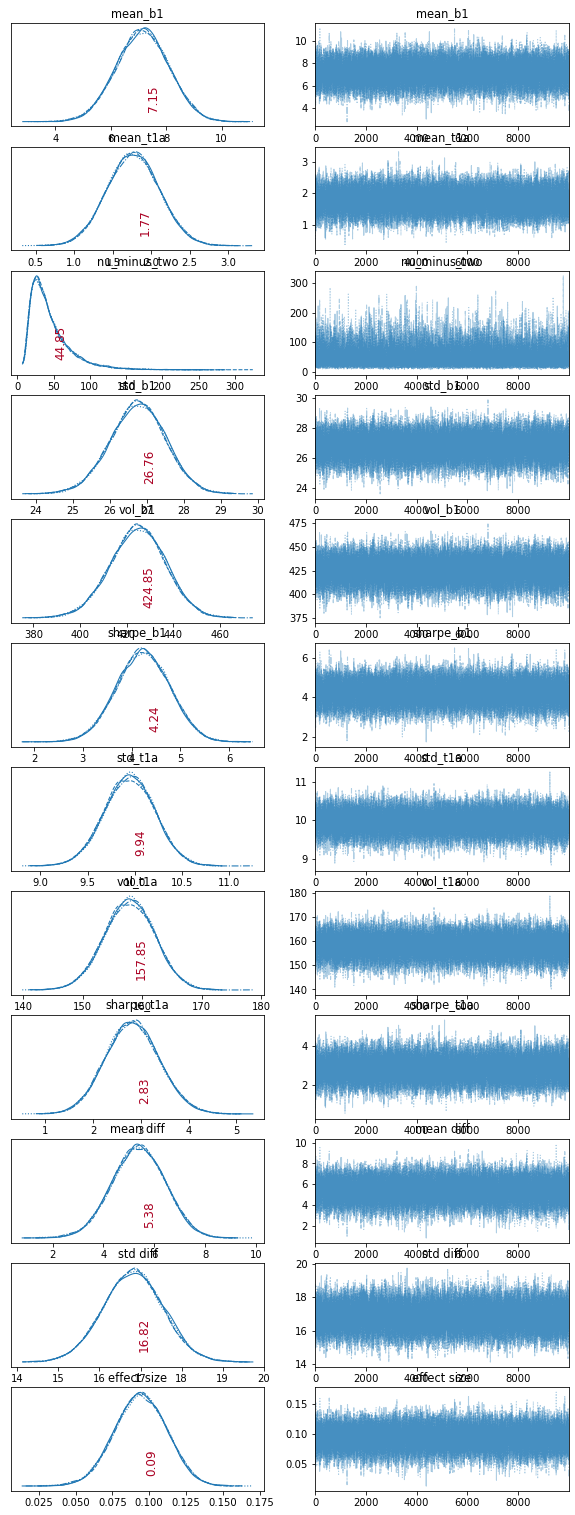

time: 10min 42s (started: 2023-03-08 22:57:16 +09:00)


In [71]:
# t1a outperforms b1 in sharpe ratio and volatility as well.
bayesian_estimate(df)

# Longer Data Period

## Settings

Run settings in [Bayesian estimation](#Bayesian-estimation) for comparison

In [5]:
start = '20130101'
end = '20181231'
df_compare = pd.DataFrame()

time: 4.92 ms (started: 2023-03-01 18:19:05 +09:00)


In [72]:
start = '20030101'
end = '20131231'
df_compare = pd.DataFrame()

time: 2.16 ms (started: 2023-03-01 20:21:00 +09:00)


In [8]:
start = '20130101'
end = '20221231'
df_compare = pd.DataFrame()

time: 2.16 ms (started: 2023-03-09 10:34:12 +09:00)


In [21]:
start = '20030101'
end = '20181231'
df_compare = pd.DataFrame()

time: 2.02 ms (started: 2023-03-09 10:39:40 +09:00)


In [22]:
symbol = '069500' # KODEX 200
df_all = fdr.DataReader(symbol, start, end)

time: 244 ms (started: 2023-03-09 10:39:41 +09:00)


In [23]:
df_bt_ori = (df_all.Close.rename_axis('dt').to_frame('close')
               .assign(custom=0))
dates_all = df_bt_ori.index

time: 3.89 ms (started: 2023-03-09 10:39:41 +09:00)


In [24]:
hold_period = 365
dates_start = df_bt_ori.loc[: dates_all[-1] - timedelta(hold_period)].index
n_dates = dates_start.size

time: 3.26 ms (started: 2023-03-09 10:39:42 +09:00)


In [25]:
dates_start

DatetimeIndex(['2003-01-02', '2003-01-03', '2003-01-06', '2003-01-07',
               '2003-01-08', '2003-01-09', '2003-01-10', '2003-01-13',
               '2003-01-14', '2003-01-15',
               ...
               '2017-12-14', '2017-12-15', '2017-12-18', '2017-12-19',
               '2017-12-20', '2017-12-21', '2017-12-22', '2017-12-26',
               '2017-12-27', '2017-12-28'],
              dtype='datetime64[ns]', name='dt', length=3715, freq=None)

time: 14 ms (started: 2023-03-09 10:39:43 +09:00)


In [26]:
kwargs_bt = {
    'init_cash': 1e7, 
    'commission': 0.00363960/100,
    'verbose': False, 
    'plot_bp':False,
    'buy_prop': 1,
    'sell_prop': 1,
    'upper_limit':0.1, 
    'lower_limit':-0.1
}

time: 958 µs (started: 2023-03-09 10:39:51 +09:00)


## Buy & Hold

In [78]:
df_bt = df_bt_ori.copy()

time: 7.52 ms (started: 2023-03-01 20:21:16 +09:00)


### CS01

In [109]:
scenario = 'b1'
n_buy = 1

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 1.09 ms (started: 2023-03-01 10:32:14 +09:00)


In [110]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

for i, start in enumerate(dates_start):
    df_bt['custom'] = 0 # reset
    df_bt.loc[start,'custom'] = -1
    
    res = run_backtest(start, df_bt, kwargs_bt)
    if res[2] <= 0:
        print('ERROR: no buy for buy&hold')
        break
    df_result.loc[i] = res
    
    n_last = print_progress(i, print_step, n_last)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 44min 15s (started: 2023-03-01 10:32:19 +09:00)


In [ ]:
df_result['return'].agg(['mean','min','max'])

In [82]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 9.77 ms (started: 2023-03-01 21:26:32 +09:00)


### CS02

In [79]:
scenario = 'b4'
n_buy = 5

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 1.14 ms (started: 2023-03-01 20:21:31 +09:00)


In [80]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

period = 40

for i, start in enumerate(dates_start):
    df_bt['custom'] = 0 # reset
    dt = dates_all[[i + x*period for x in range(n_buy)]]
    df_bt.loc[dt,'custom'] = -1
    
    res = run_backtest(start, df_bt, kwargs_bt)
    if res[2] <= 0:
        print('ERROR: no buy for buy&hold')
        break
    df_result.loc[i] = res
    n_last = print_progress(i, print_step, n_last)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 1h 4min 59s (started: 2023-03-01 20:21:33 +09:00)


In [81]:
df_result['return'].agg(['mean','min','max'])

mean     7.805935
min    -32.147372
max     34.243090
Name: return, dtype: float64

time: 14.3 ms (started: 2023-03-01 21:26:32 +09:00)


In [82]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 9.77 ms (started: 2023-03-01 21:26:32 +09:00)


## MACD

In [58]:
df_bt = df_bt_ori.copy()
df_macd = calc_macd(df_bt['close'])

time: 8.66 ms (started: 2023-03-09 13:18:54 +09:00)


In [59]:
df_ti = df_macd

cond = (df_ti.macd > df_ti.macd_signal) 
cond = cond & (df_ti.macd < 0)
df_bt.loc[cond, 'custom'] = -1

cond = (df_ti.macd < df_ti.macd_signal) 
cond = cond & (df_ti.macd > 0)
df_bt.loc[cond, 'custom'] = 1

time: 14 ms (started: 2023-03-09 13:18:55 +09:00)


In [60]:
df_bt = finish_custom(df_bt)

time: 817 ms (started: 2023-03-09 13:18:56 +09:00)


In [61]:
# small number of chance to buy
df_bt.custom.value_counts()

 0    3747
 1     128
-1      84
Name: custom, dtype: int64

time: 17.2 ms (started: 2023-03-09 13:18:57 +09:00)


### CS01

In [65]:
scenario = 't1a'

kwargs_bt.update({
    'buy_prop': 1,
    'sell_prop': 1
})

time: 1.21 ms (started: 2023-03-09 13:20:48 +09:00)


In [66]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 2h 34min 25s (started: 2023-03-09 13:20:49 +09:00)


In [67]:
df_result['return'].agg(['mean','min','max'])

mean     3.363048
min    -40.536651
max     36.161510
Name: return, dtype: float64

time: 23 ms (started: 2023-03-09 15:55:15 +09:00)


In [68]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 57.8 ms (started: 2023-03-09 15:55:15 +09:00)


### CS02

In [64]:
#dates_start = df_bt.loc[:'2017-12-31'].index

time: 4.57 ms (started: 2023-03-01 19:34:21 +09:00)


In [50]:
scenario = 't1c'

kwargs_bt.update({
    'buy_prop': .2,
    'sell_prop': .2
})

time: 1.18 ms (started: 2023-03-09 11:43:47 +09:00)


In [51]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
time: 1h 29min 12s (started: 2023-03-09 11:43:47 +09:00)


In [52]:
df_result['return'].agg(['mean','min','max'])

mean     1.528586
min    -18.268321
max     11.504092
Name: return, dtype: float64

time: 39.9 ms (started: 2023-03-09 13:13:00 +09:00)


In [54]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 14 ms (started: 2023-03-09 13:13:00 +09:00)


In [69]:
df_compare.to_csv('df_compare_2.csv')

time: 393 ms (started: 2023-03-09 15:55:15 +09:00)


## Comparison

In [6]:
files = [f'df_compare_{x}.csv' for x in [1,2]]

df_compare = pd.DataFrame()
for f in files:
    df_compare = pd.concat([df_compare, pd.read_csv(f, parse_dates=['start'])])

df_compare = df_compare.drop_duplicates(subset=['scenario','start']).set_index('start')

time: 126 ms (started: 2023-03-09 22:01:14 +09:00)


In [7]:
df = df_compare.reset_index().groupby('scenario')['start'].agg(['min','max','count'])
df

min        max  count
scenario                             
b1       2003-01-02 2021-12-29   4700
b2       2018-01-02 2021-12-29    985
b3       2018-01-02 2021-12-29    985
b4       2003-01-02 2021-12-29   4700
t1a      2003-01-02 2021-12-29   4700
t1b      2018-01-02 2021-12-29    985
t1c      2003-01-02 2021-12-29   4700
t1d      2018-01-02 2021-12-29    985
t2a      2018-01-02 2021-12-29    985
t2b      2018-01-02 2021-12-29    985
t2c      2018-01-02 2021-12-29    985
t2d      2018-01-02 2021-12-29    985
t3       2018-01-02 2021-12-29    985

time: 53 ms (started: 2023-03-09 22:01:15 +09:00)


### CS01

In [8]:
models = ['b4','t1c']
start = '2018-01-01'

time: 760 µs (started: 2023-03-09 22:03:37 +09:00)


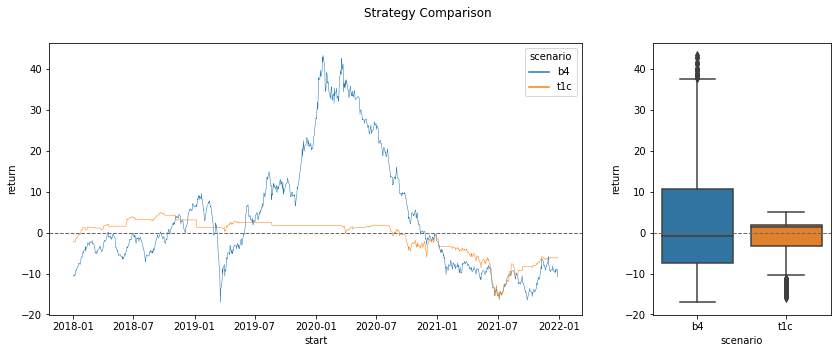

time: 1.17 s (started: 2023-03-09 22:07:47 +09:00)


In [17]:
df = df_compare.copy()
df = (df.loc[df.scenario.isin(models)]
        .dropna(subset='return')
        .loc[start:]
        .sort_values(by=['scenario'])
)
compare_models(df)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [std_t1c, mean_t1c, std_b4, mean_b4, nu_minus_two]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 273 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


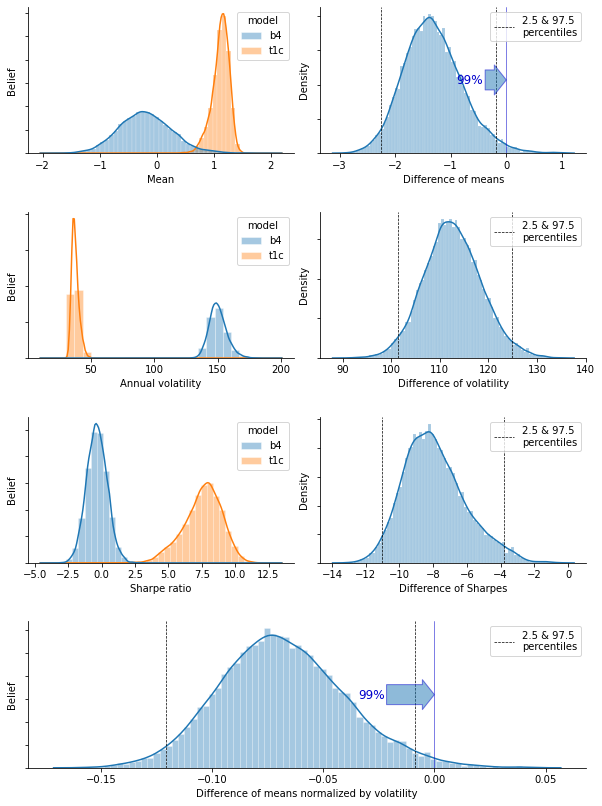

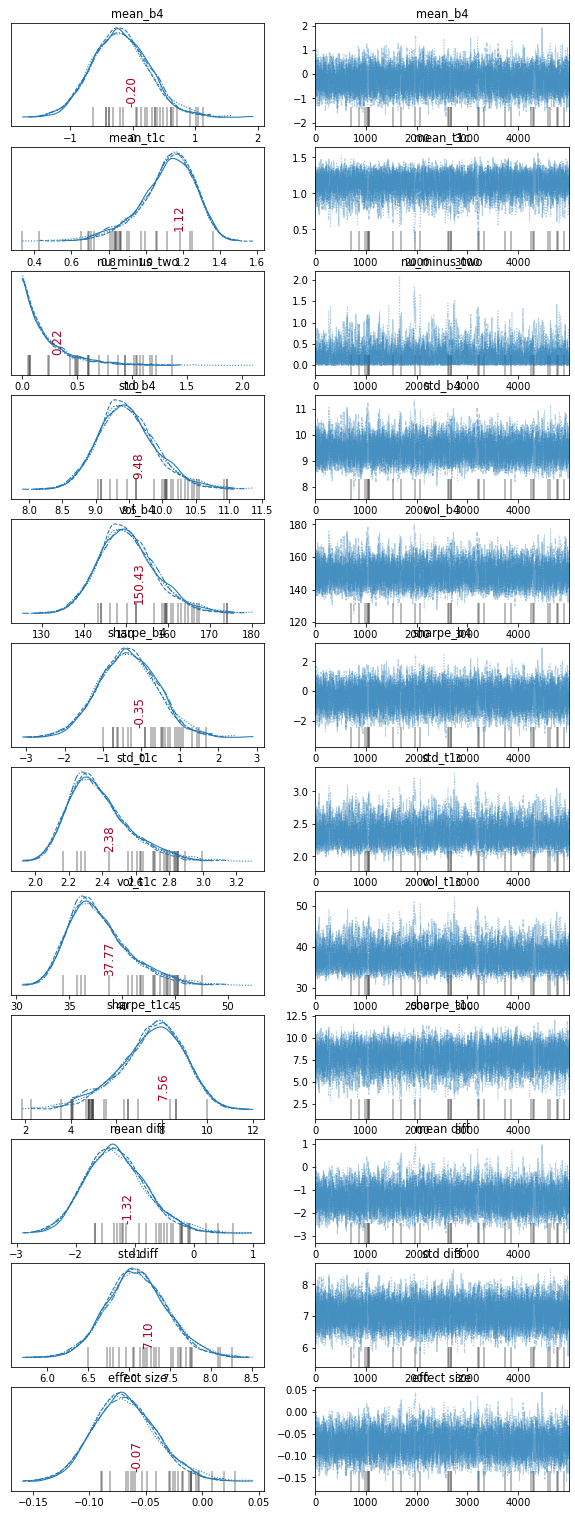

time: 6min 41s (started: 2023-03-09 22:07:54 +09:00)


In [18]:
df = df.reset_index().set_index(['scenario', 'start']).squeeze()
bayesian_estimate(df, chains=4, draws=5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [std_t1c, mean_t1c, std_b4, mean_b4, nu_minus_two]


Sampling 4 chains for 2_500 tune and 10_000 draw iterations (10_000 + 40_000 draws total) took 583 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8278754089932537, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


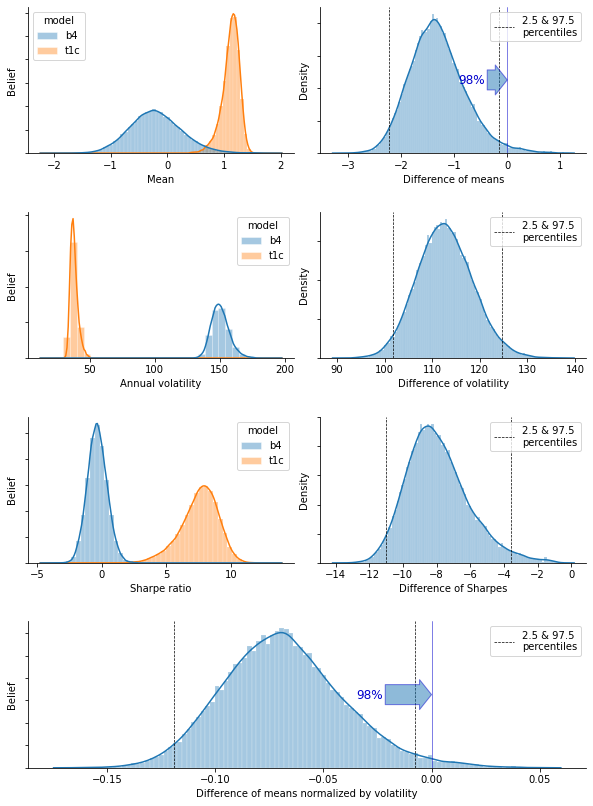

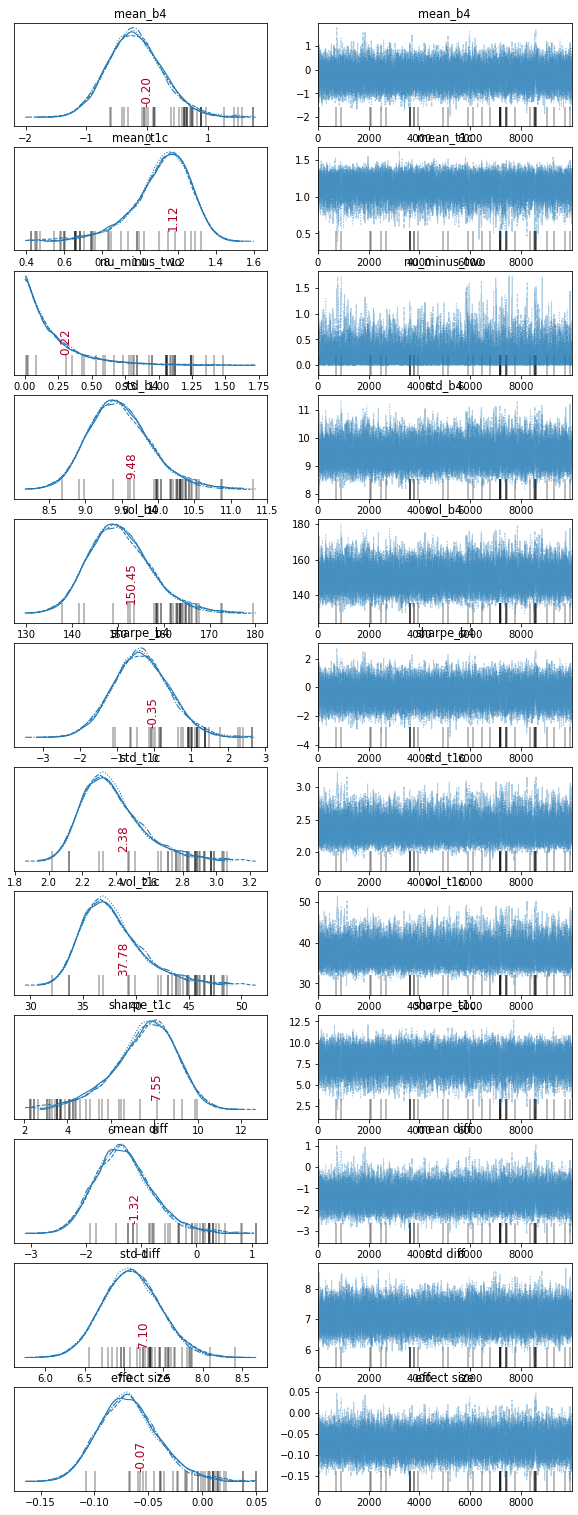

time: 12min 53s (started: 2023-03-09 22:16:41 +09:00)


In [19]:
# similar result with different args
bayesian_estimate(df)

### CS02

In [20]:
models = ['b4','t1c']
end = '2017-12-31'

time: 1.03 ms (started: 2023-03-09 22:32:46 +09:00)


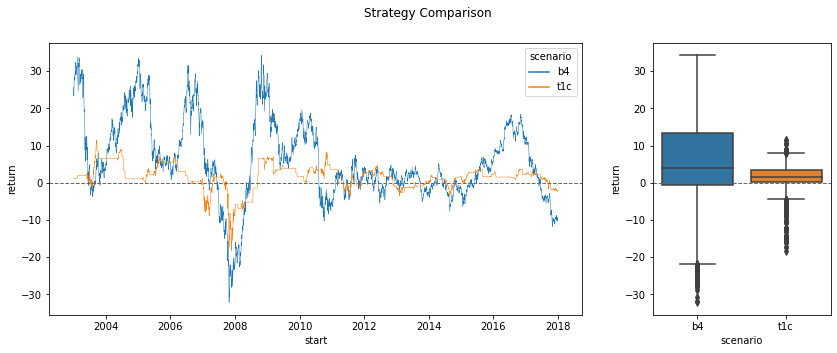

time: 1.45 s (started: 2023-03-09 22:32:50 +09:00)


In [21]:
df = df_compare.copy()
df = (df.loc[df.scenario.isin(models)]
        .dropna(subset='return')
        .loc[:end]
        .sort_values(by=['scenario'])
)
compare_models(df)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [std_t1c, mean_t1c, std_b4, mean_b4, nu_minus_two]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 340 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


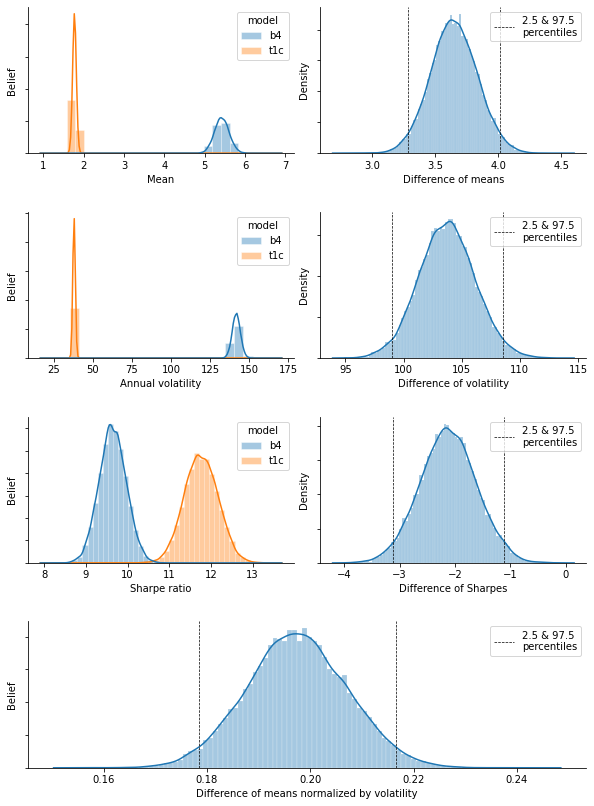

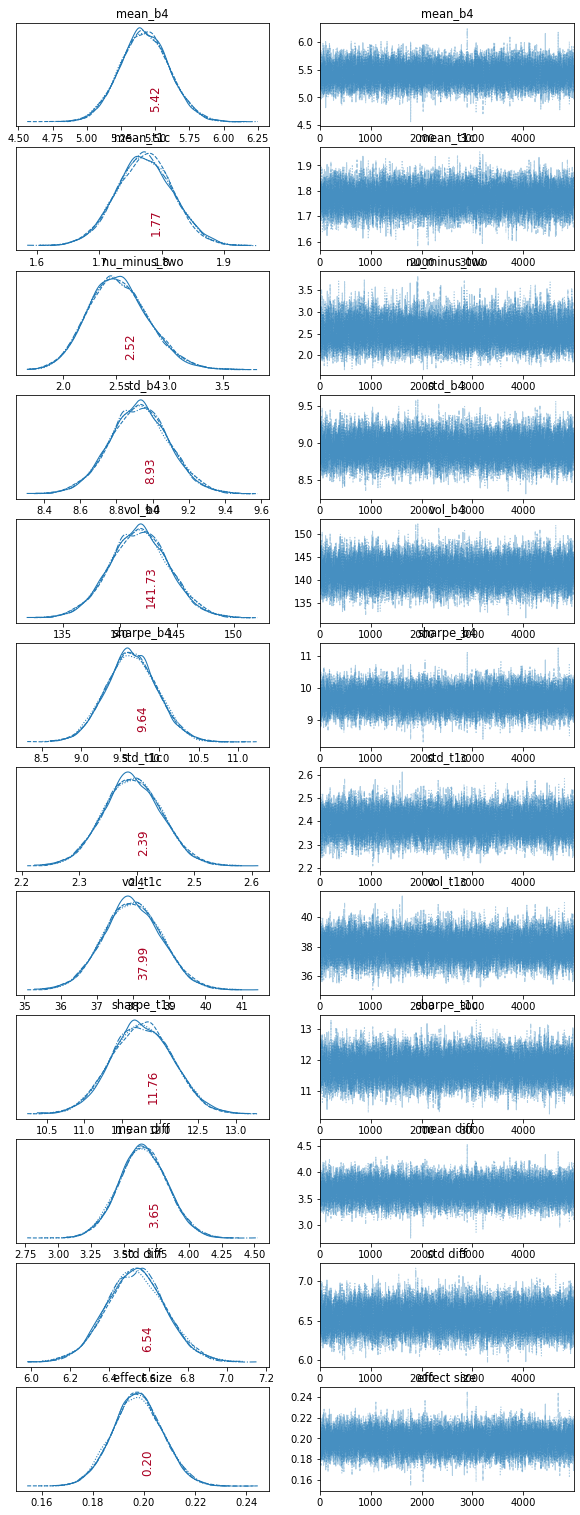

time: 8min 22s (started: 2023-03-09 22:32:52 +09:00)


In [22]:
df = df.reset_index().set_index(['scenario', 'start']).squeeze()
bayesian_estimate(df, chains=4, draws=5000, tune=1000)

### CS03

In [23]:
models = ['b4','t1c']

time: 1.41 ms (started: 2023-03-09 22:42:44 +09:00)


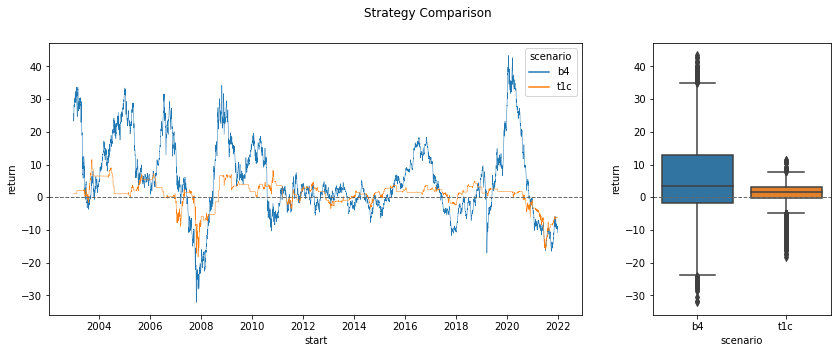

time: 1.69 s (started: 2023-03-09 22:42:55 +09:00)


In [24]:
df = df_compare.copy()
df = (df.loc[df.scenario.isin(models)]
        .dropna(subset='return')
        .sort_values(by=['scenario'])
)
compare_models(df)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [std_t1c, mean_t1c, std_b4, mean_b4, nu_minus_two]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 408 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


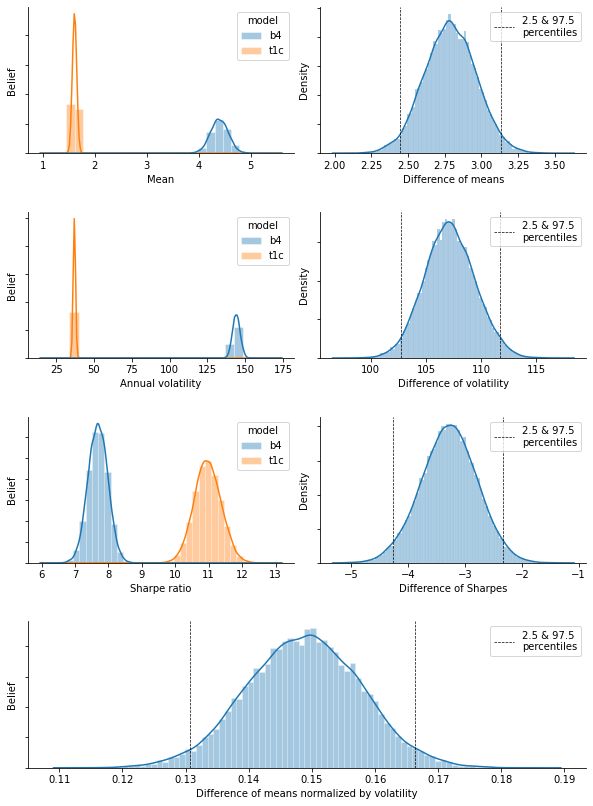

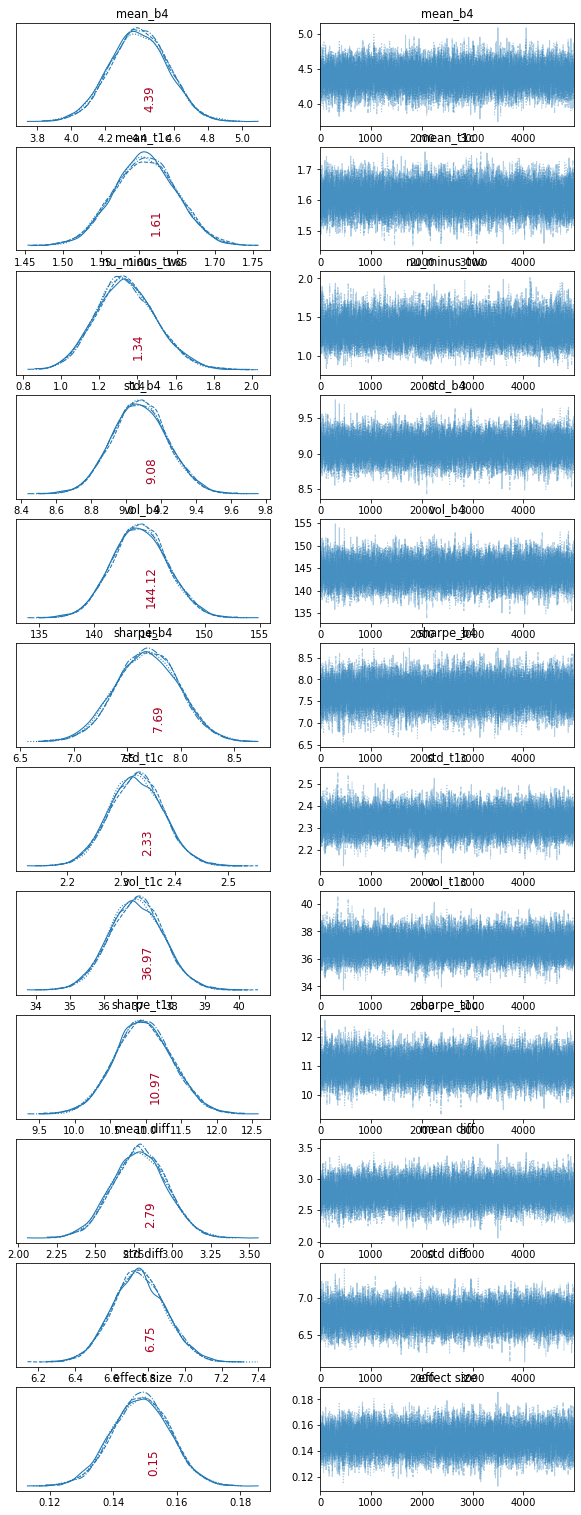

time: 9min 47s (started: 2023-03-09 22:43:04 +09:00)


In [25]:
df = df.reset_index().set_index(['scenario', 'start']).squeeze()
bayesian_estimate(df, chains=4, draws=5000, tune=1000)

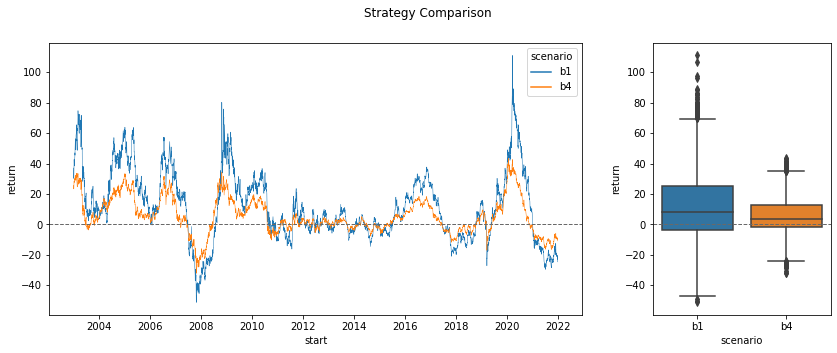

time: 1.93 s (started: 2023-03-09 19:28:08 +09:00)


In [61]:
models = ['b1','b4']
df = df_compare.copy()
df = (df.loc[df.scenario.isin(models)]
        .dropna(subset='return')
        #.loc[df.start < '2018-01-01']
        .sort_values(by=['scenario'])
)
compare_models(df)

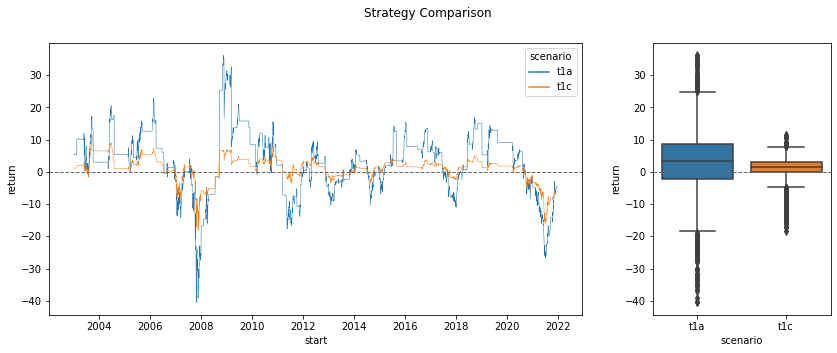

time: 2.09 s (started: 2023-03-09 19:28:36 +09:00)


In [63]:
models = ['t1a','t1c']
df = df_compare.copy()
df = (df.loc[df.scenario.isin(models)]
        .dropna(subset='return')
        #.loc[df.start < '2018-01-01']
        .sort_values(by=['scenario'])
)
compare_models(df)

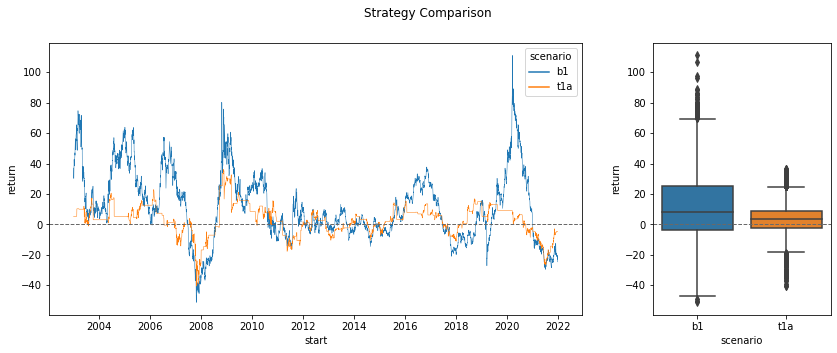

time: 2.06 s (started: 2023-03-09 19:29:41 +09:00)


In [64]:
models = ['b1','t1a']
df = df_compare.copy()
df = (df.loc[df.scenario.isin(models)]
        .dropna(subset='return')
        #.loc[df.start < '2018-01-01']
        .sort_values(by=['scenario'])
)
compare_models(df)

In [11]:
df = df.set_index(['scenario', 'start']).squeeze()

time: 15.1 ms (started: 2023-03-02 08:24:25 +09:00)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [std_t1c, mean_t1c, std_b4, mean_b4, nu_minus_two]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 441 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


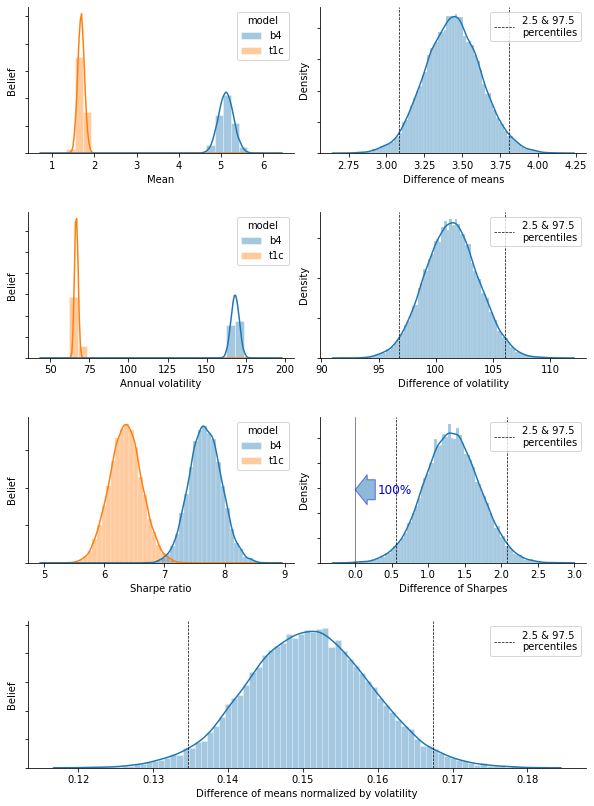

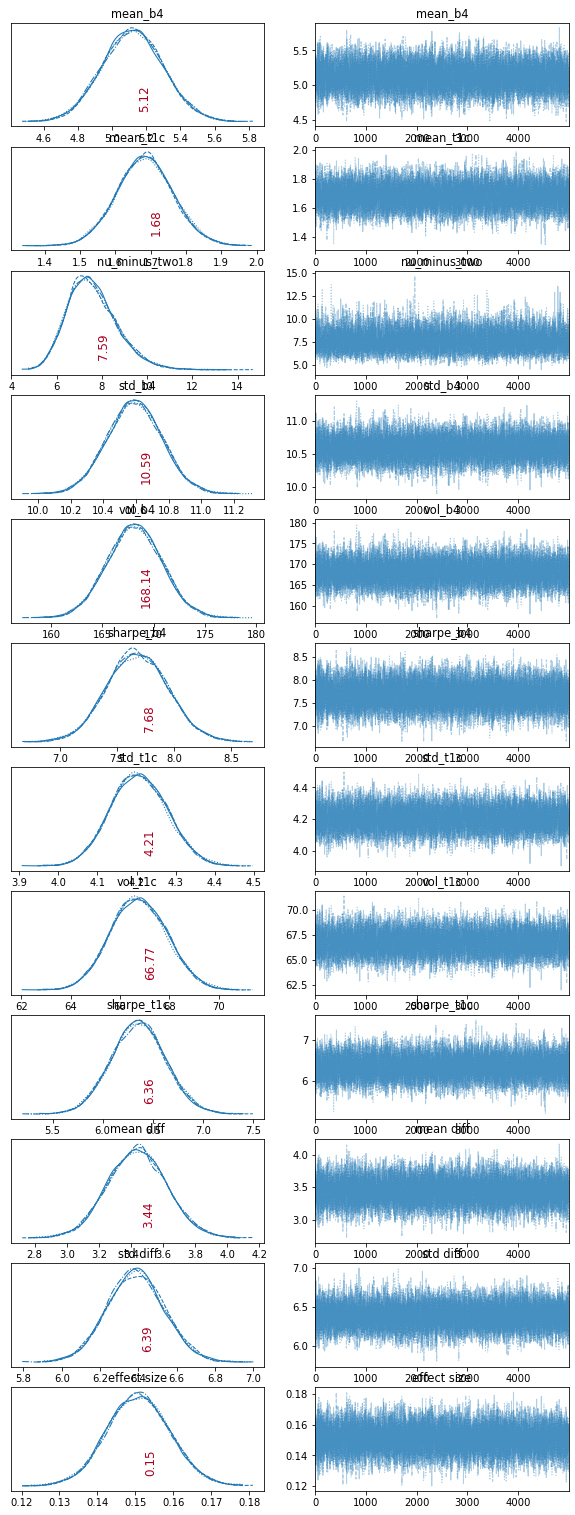

time: 10min 28s (started: 2023-03-01 23:21:02 +09:00)


In [16]:
bayesian_estimate(df, chains=4, draws=5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [std_t1a, mean_t1a, std_b1, mean_b1, nu_minus_two]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 323 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


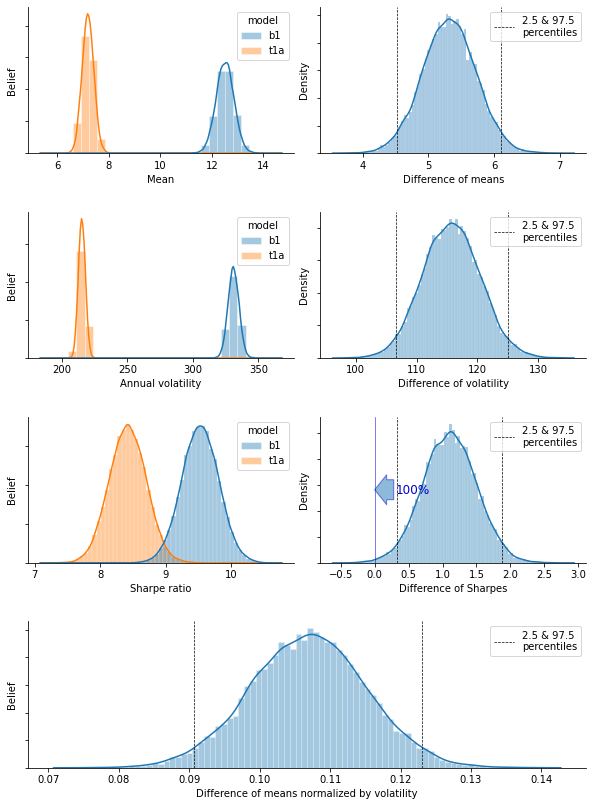

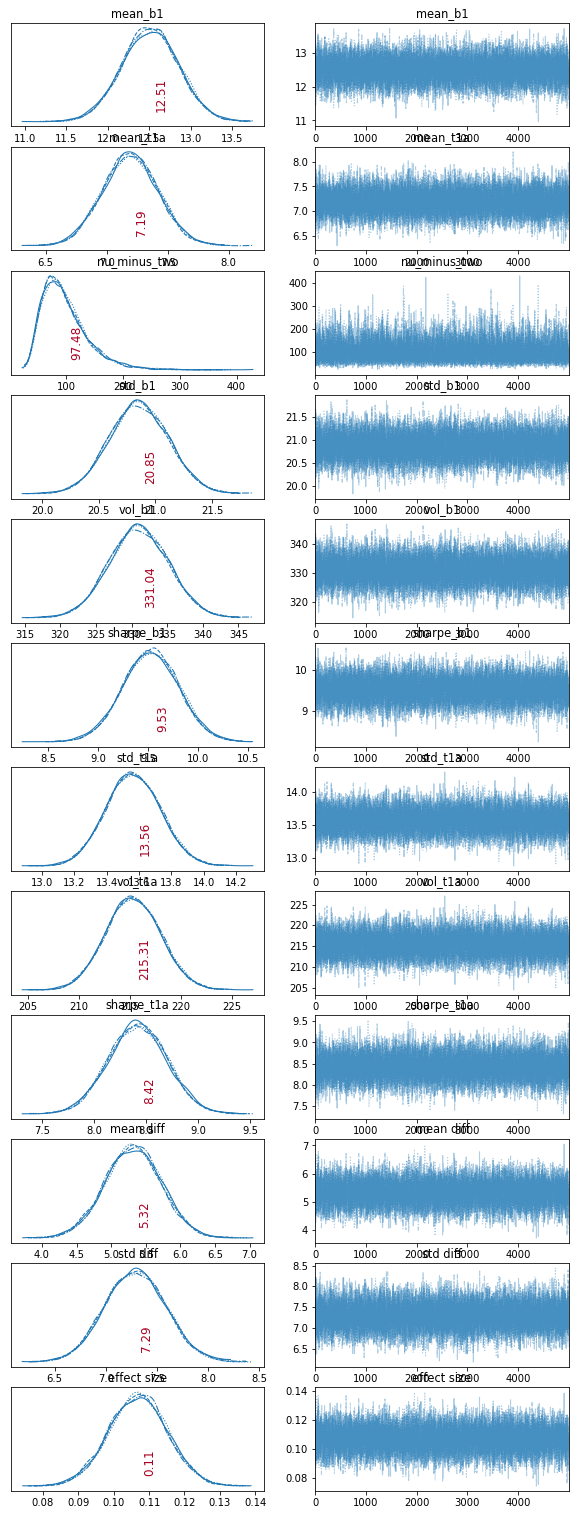

time: 7min 53s (started: 2023-03-01 14:08:36 +09:00)


In [13]:
# for 15 yrs
bayesian_estimate(df, chains=4, draws=5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [std_t1a, mean_t1a, std_b1, mean_b1, nu_minus_two]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 441 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


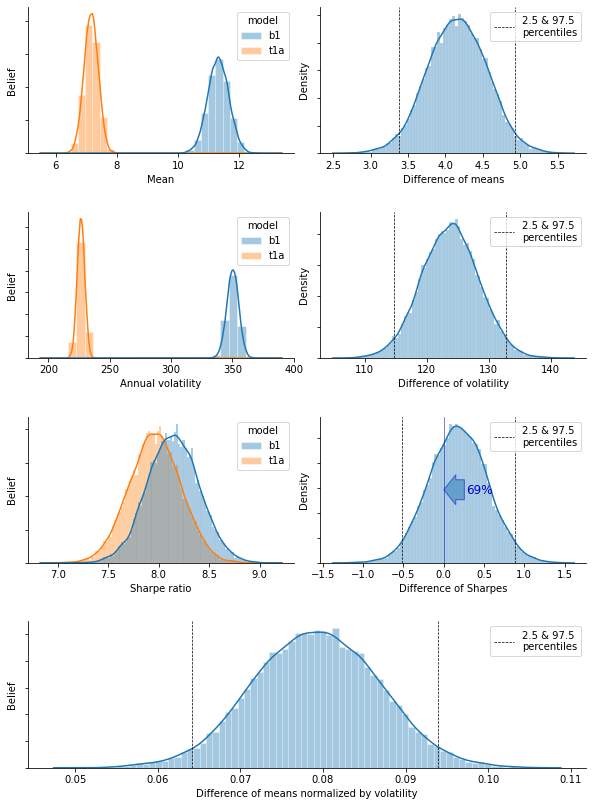

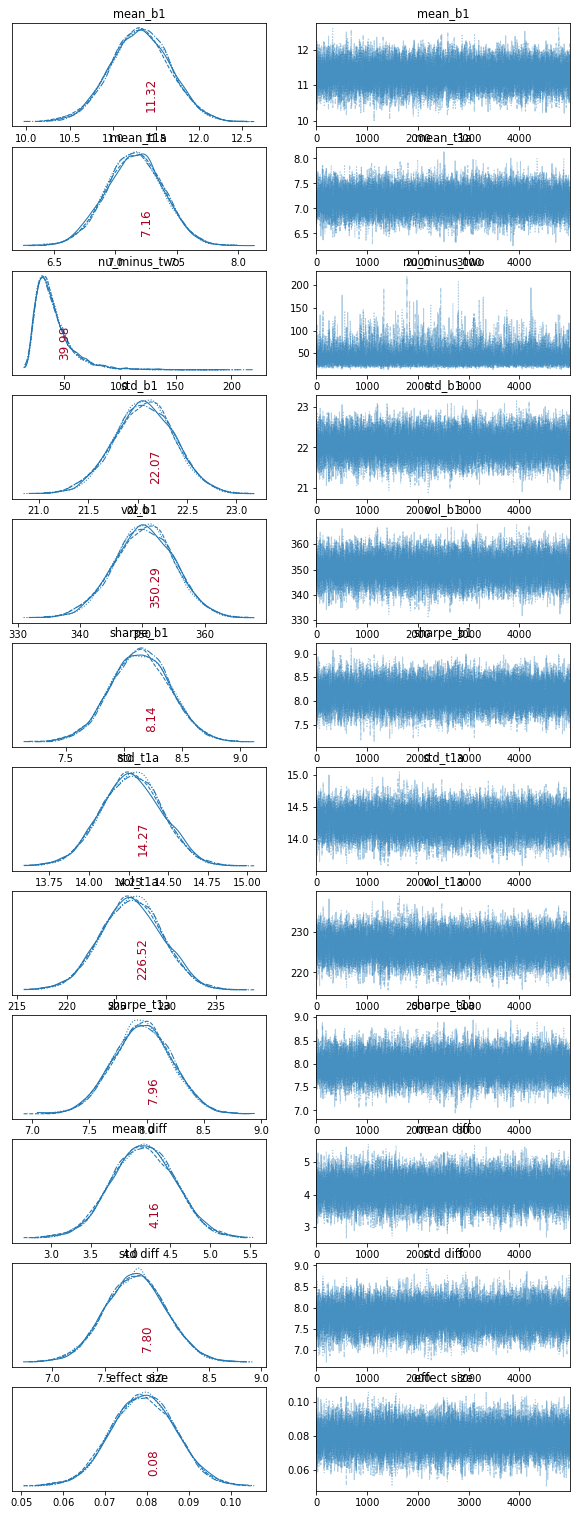

time: 10min 9s (started: 2023-03-01 14:21:10 +09:00)


In [17]:
# for 19 yrs
bayesian_estimate(df, chains=4, draws=5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [std_b4, mean_b4, std_b1, mean_b1, nu_minus_two]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 456 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


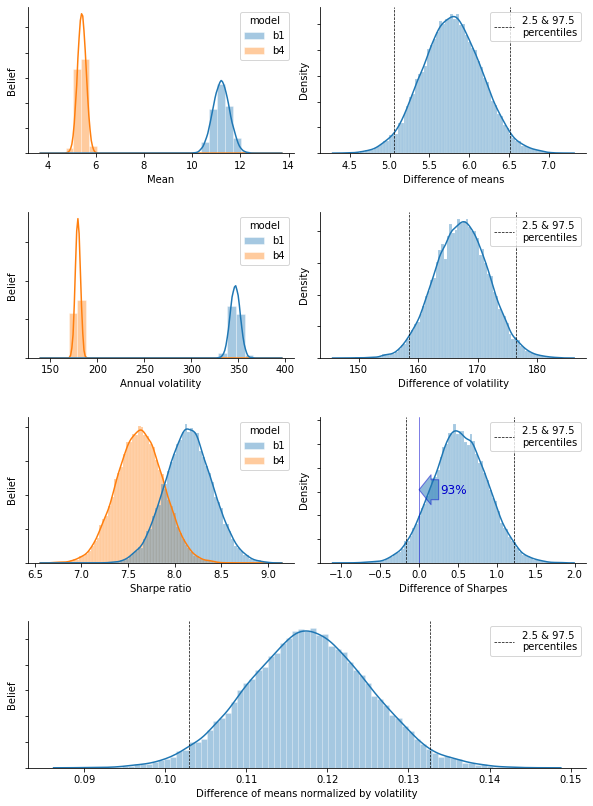

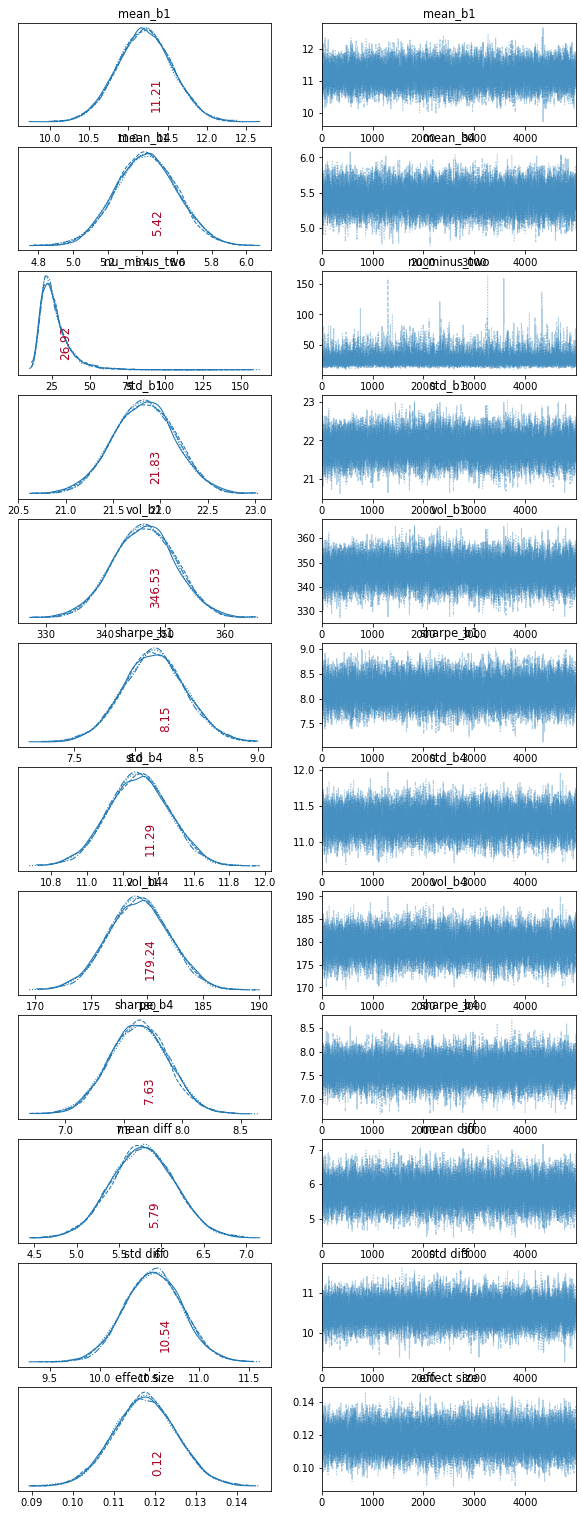

time: 10min 39s (started: 2023-03-02 08:24:43 +09:00)


In [12]:
bayesian_estimate(df, chains=4, draws=5000, tune=1000)

# Time Horizon

Run settings in [Bayesian estimation](#Bayesian-estimation) for comparison

In [67]:
start = '20030101'
end = '20221231'
df_compare = pd.DataFrame()

time: 2.28 ms (started: 2023-03-05 20:50:39 +09:00)


In [68]:
symbol = '069500' # KODEX 200
df_all = fdr.DataReader(symbol, start, end)

time: 294 ms (started: 2023-03-05 20:50:40 +09:00)


In [69]:
df_bt = df_all.Close.rename_axis('dt').to_frame('close')

time: 2.63 ms (started: 2023-03-05 20:50:41 +09:00)


In [70]:
#df_bt.reset_index().dt.dt.year.value_counts().sort_index()
y = df_bt.reset_index().dt.dt.year.value_counts().mean()
year = round(y)
year

247

time: 27.9 ms (started: 2023-03-05 20:50:42 +09:00)


In [71]:
years = [1,2,5,10]
df_result = pd.DataFrame()

for y in years:
    df = df_bt.pct_change(y*year).assign(scenario=y)
    df_result = pd.concat([df_result, df])
df_result.index.name = 'start'
df_result = df_result.rename(columns={'close':'return'})

time: 37.6 ms (started: 2023-03-05 20:50:43 +09:00)


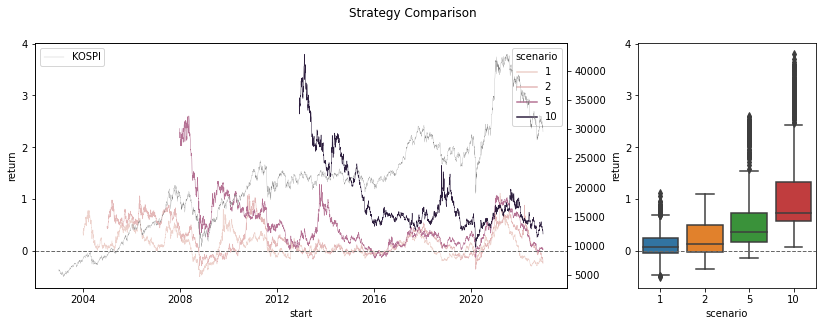

time: 2.42 s (started: 2023-03-05 20:50:58 +09:00)


In [73]:
ax, _ = compare_models(df_result, return_axes=True)
_ = df_bt.rename(columns={'close':'KOSPI'}).plot(ax=ax.twinx(), c='grey', lw=0.2)

In [78]:
df = (df_result.loc[df_result.scenario.isin([1,10])]
               .reset_index()
               .set_index(['scenario', 'start']).squeeze())

time: 32.7 ms (started: 2023-03-05 20:53:29 +09:00)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [std_10, mean_10, std_1, mean_1, nu_minus_two]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 407 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


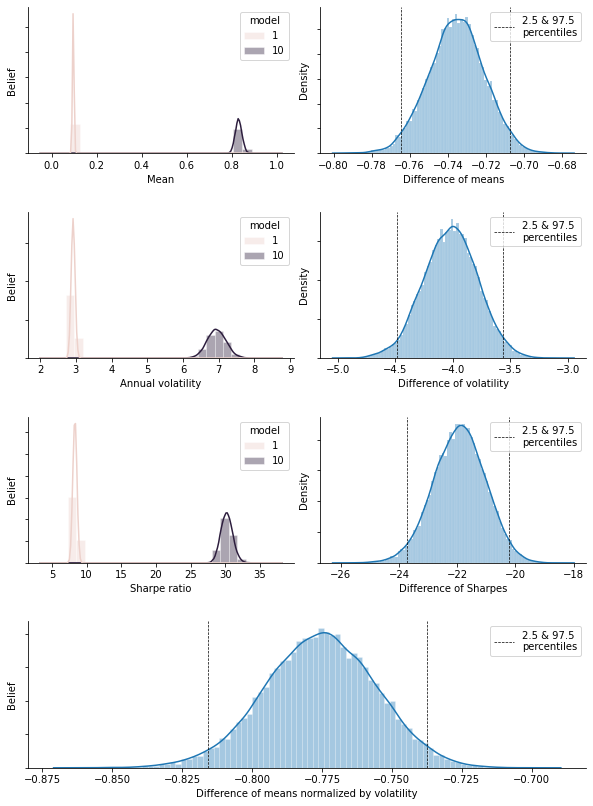

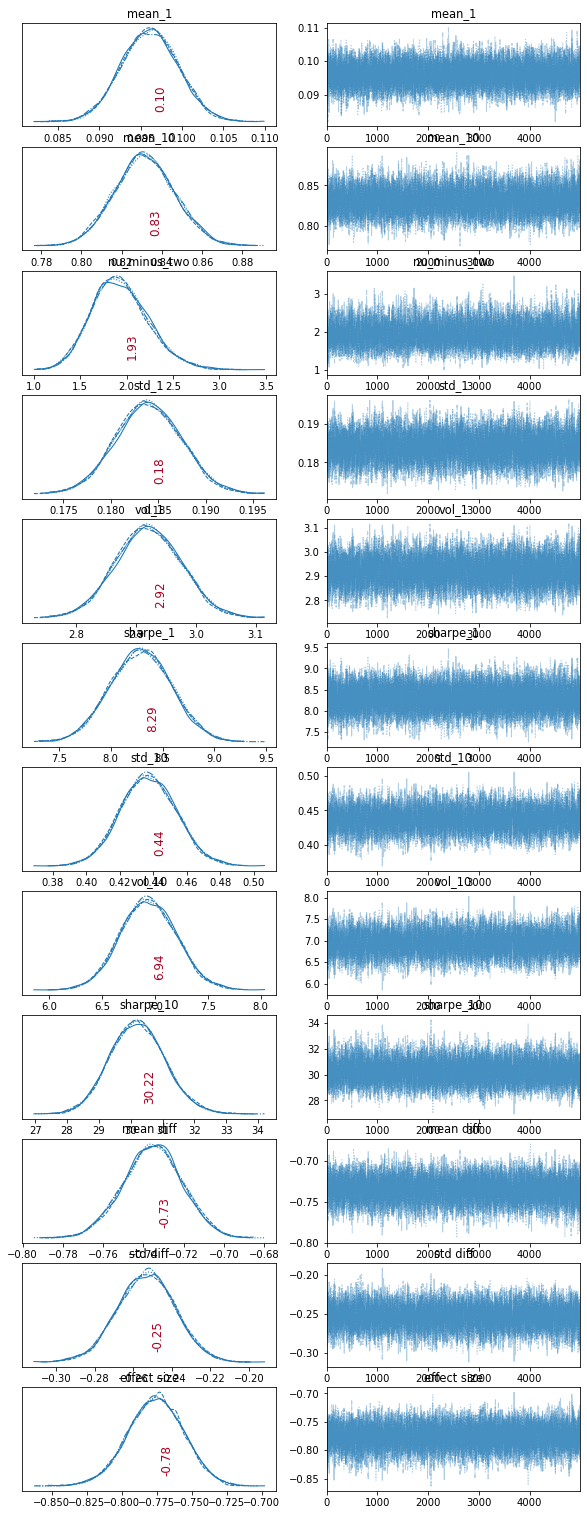

time: 9min 37s (started: 2023-03-05 20:53:56 +09:00)


In [82]:
bayesian_estimate(df, chains=4, draws=5000, tune=1000)

# KODEX 200

In [3]:
start = '20180101'
end = '20221231'

symbol = '069500' # KODEX 200
df_all = fdr.DataReader(symbol, start, end)

time: 290 ms (started: 2023-03-05 18:48:23 +09:00)


In [23]:
close = (df_all['Close']
         .loc['2020':]
        )
hmax = close.cummax()
daily_drawdown = close / hmax - 1
hdd = daily_drawdown.cummin()
mdd = -hdd.min()

time: 25.9 ms (started: 2023-03-05 19:57:42 +09:00)


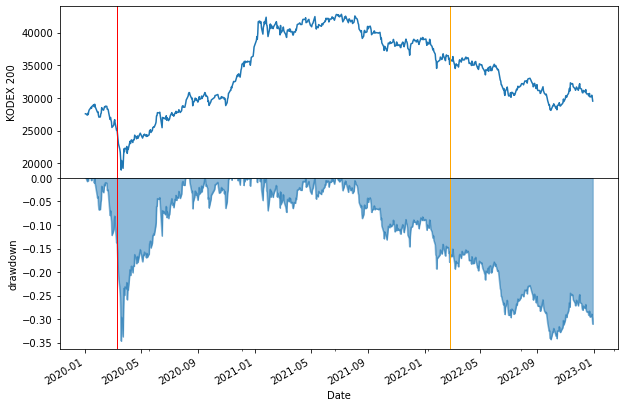

time: 1.26 s (started: 2023-03-05 21:59:27 +09:00)


In [89]:
from matplotlib import pyplot as plt
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,7), sharex=True)

close.plot(ax=ax1)
_ = daily_drawdown.plot.area(ax=ax2, alpha=0.5)

cs = {'2020-03-11':'red', '2022-02-24':'orange'}
for d,c in cs.items():
    _ = [x.axvline(d, c=c, lw=1) for x in [ax1, ax2]]

ax1.set_ylabel('KODEX 200')
ax2.set_ylabel('drawdown')

plt.subplots_adjust(hspace=0)
#ax2.autoscale(axis='x', tight=True)
plt.show()

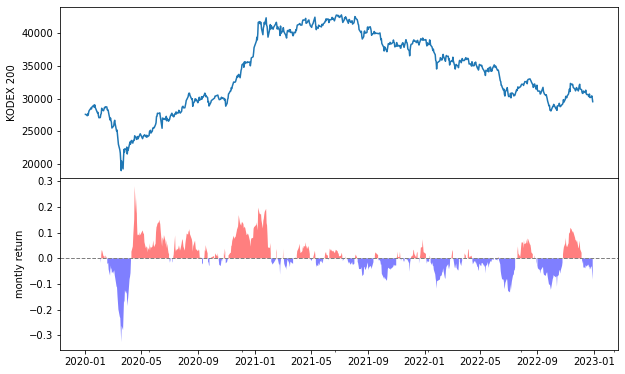

time: 1.14 s (started: 2023-03-05 20:48:23 +09:00)


In [66]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,7), sharex=True)
close.plot(ax=ax1)

#close.pct_change(20).plot(ax=ax2)
df = close.pct_change(20)
ax2.fill_between(close.index, df, 0, where=df > 0, facecolor='red', alpha=.5)
ax2.fill_between(close.index, df, 0, where=df < 0, facecolor='blue', alpha=.5)

ax1.set_ylabel('KODEX 200')
ax2.set_ylabel('montly return')
ax2.axhline(0, ls='--', c='grey', lw=1)
plt.subplots_adjust(hspace=0)
plt.show()